# Introduction

US-based Surprise Housing is entering Australian market. The company buys properties at a lower rate and makes profit by sells at higher rate. The company wants a mode to know 
- which variables are significant in predicting the price of the house
- how well those variables describe the price of the house

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from seaborn_qqplot import pplot
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import statsmodels
import statsmodels.api as sm
# console and other settings 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read the data
housing = pd.read_csv('train.csv')
housing.shape

(1460, 81)

# 1. Data understanding and cleaning

In [3]:
# Drop Id column and make a copy of the housing dataframe
housing_copy = housing
housing.drop(columns='Id', axis=1, inplace=True)

In [4]:
# Compute the null values per column
(housing.isnull().sum()/len(housing.index)).sort_values(ascending=False).head(21)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtCond        0.025342
BsmtQual        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
MSSubClass      0.000000
Fireplaces      0.000000
dtype: float64

The variable PoolQC has 99% values as null/NaN. The Pool Quality is relevant only if the property has a pool. There is one more variable PoolArea which denotes the size of the pool. Lets try to check PoolQC for properties in association with PoolArea.

In [5]:
# print the number of records PoolQC other than NaN
print(housing[~housing.PoolQC.isna()][['PoolQC', 'PoolArea']])

print("\nProperties with null PoolArea information", len(housing[housing.PoolArea.isnull()]))
print("\n", housing[housing.PoolArea != 0][['PoolQC', 'PoolArea']])
print("\nProperties without PoolArea", len(housing[housing.PoolArea == 0]))

     PoolQC  PoolArea
197      Ex       512
810      Fa       648
1170     Gd       576
1182     Ex       555
1298     Gd       480
1386     Fa       519
1423     Gd       738

Properties with null PoolArea information 0

      PoolQC  PoolArea
197      Ex       512
810      Fa       648
1170     Gd       576
1182     Ex       555
1298     Gd       480
1386     Fa       519
1423     Gd       738

Properties without PoolArea 1453


The PoolQC is null for records with PoolArea of 0. So as per the data definition, we can impute the PoolQC as NA i.e. No Pool for rows where PoolArea is 0.

In [6]:
#Impute PoolQC as NA i.e. No Pool for rows where PoolArea is 0.
housing['PoolQC'] = housing.PoolQC.fillna('NA')

In [7]:
# Lets analyse the values for MiscFeatures
housing.MiscFeature.value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [8]:
# We can drop MiscFeature column as it has very few values 
housing.drop(columns='MiscFeature', axis=1, inplace=True)

In [9]:
# Lets analyze Alley
housing.Alley.value_counts()
#housing[housing.Alley.isnull()].Alley

Grvl    50
Pave    41
Name: Alley, dtype: int64

Unlike PoolQC, we can not take cue from other columns for Alley. Also the number of records are very less so we can drop this column 

In [10]:
# We can drop Alley column as it has very few values 
housing.drop(columns='Alley', axis=1, inplace=True)

In [11]:
# Now lets analyze Fence
housing.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

We can drop this column as nearly 80% records have null values.

In [12]:
# We can drop Fence column as it has very few values 
housing.drop(columns='Fence', axis=1, inplace=True)

In [13]:
print("Number of records with FireplaceQu as null", len(housing[housing.FireplaceQu.isnull()]))

housing[housing.Fireplaces == 0 & housing.FireplaceQu.isna()][['Fireplaces', 'FireplaceQu']]

Number of records with FireplaceQu as null 690


,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN
...,...,...
1452,0,NaN
1453,0,NaN
1454,0,NaN
1458,0,NaN


We can use Fireplaces to impute FireplaceQu with NA for properties without Fireplaces.

In [14]:
# Impute FireplaceQu with NA for properties without Fireplaces.
housing['FireplaceQu'] = housing.FireplaceQu.fillna('NA')

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


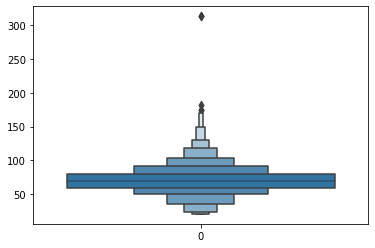

In [15]:
# LotFrontage
print(housing.LotFrontage.describe())
sns.boxenplot(data=housing.LotFrontage)
plt.show()

LotFrontage has few outliers max being 313. The difference between the mean and median of LotFrontage is very small, so we can impute the null values in LotFrontage with median.

All the following columns have same number of null values 
- GarageYrBlt     0.055479
- GarageCond      0.055479
- GarageType      0.055479
- GarageFinish    0.055479
- GarageQual      0.055479

Lets check what is the size of garage for these records, if size is 0 we can impute these values with NA i.e. the property does not have garage.

In [16]:
print(len(housing[housing.GarageYrBlt.isna()][['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 
                                     'GarageQual', 'GarageArea', 'GarageCars']]))

housing[housing.GarageYrBlt.isna()][['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 
                                     'GarageQual', 'GarageArea', 'GarageCars']]

81


,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,GarageArea,GarageCars
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


In [17]:
# Lets calculate the % of records for which GarageYrBlt is null and GarageArea is zero
len(housing[housing.GarageArea == 0 & housing.GarageYrBlt.isna()])

81

While other columns related to Garage can be imputed with NA i.e. No Garage, GarageYrBlt needs to be imputed separately. Lets analyse the GarageYrBlt column.

In [18]:
housing.GarageCond.fillna('NA', inplace=True)
housing.GarageType.fillna('NA', inplace=True)
housing.GarageFinish.fillna('NA', inplace=True)
housing.GarageQual.fillna('NA', inplace=True)

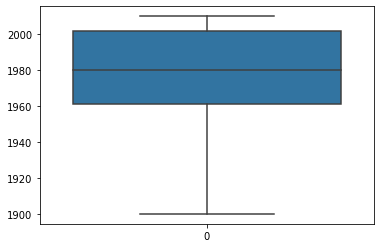

In [19]:
sns.boxplot(data=housing.GarageYrBlt)
plt.show()

**The GarageYrBlt does not have any outliers, we can replace the null values with median of the column. However we will do it post train-test split.**

In [20]:
# List colimns with high null values
(housing.isnull().sum()/len(housing.index)).sort_values(ascending=False).head(10)

LotFrontage     0.177397
GarageYrBlt     0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [21]:
housing.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

The mean and median are very similiar for LotFrontage. We will imput the null with mean after train-test split.

In [22]:
# BsmtExposure
housing[housing.BsmtFinType2.isna() | housing.BsmtFinType1.isna()][['BsmtExposure', 'BsmtFinType1', 
                                                                     'BsmtFinType2', 'BsmtQual', 
                                                                     'BsmtCond', 'BsmtFinSF1', 
                                                                     'BsmtFinSF2', 'BsmtUnfSF', 
                                                                     'TotalBsmtSF']]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0,0,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0,0,0
182,NaN,NaN,NaN,NaN,NaN,0,0,0,0
259,NaN,NaN,NaN,NaN,NaN,0,0,0,0
332,No,GLQ,NaN,Gd,TA,1124,479,1603,3206
342,NaN,NaN,NaN,NaN,NaN,0,0,0,0
362,NaN,NaN,NaN,NaN,NaN,0,0,0,0


For row 332, the BsmtFinType2 is NaN when the values are present for BsmtFinSF2 and BsmtUnfSF. We will remove this row.

In [23]:
housing = housing[housing.index != 332]

In [24]:
# Impute basement related columns with NA as both BsmtFinSF1 and BsmtFinSF2 are 0
housing.BsmtExposure.fillna('NA', inplace=True)
housing.BsmtFinType1.fillna('NA', inplace=True)
housing.BsmtFinType2.fillna('NA', inplace=True)
housing.BsmtQual.fillna('NA', inplace=True)
housing.BsmtCond.fillna('NA', inplace=True)

/home/rajeev/personal/ms_ml_ai/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [25]:
# Drop rows where MasVnrType and MasVnrArea are null as there are only 8 such rows
housing = housing[~housing.MasVnrType.isna()]
housing = housing[~housing.MasVnrType.isna()]

In [26]:
# Drop rows with Electrical value is null. There is only 1 such row
housing = housing[~housing.Electrical.isna()]

In [27]:
housing[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt
count,1450.000000,1450.000000,1369.000000
mean,1971.070345,1984.746897,1978.335281
std,30.189039,20.652271,24.685820
min,1872.000000,1950.000000,1900.000000
25%,1954.000000,1966.000000,1961.000000
50%,1972.000000,1993.000000,1979.000000
75%,2000.000000,2004.000000,2002.000000
max,2010.000000,2010.000000,2010.000000


In [28]:
housing.GarageYrBlt.isna().sum()

81

Datatype of some columns is int but they are more of categorical variables. We will convert these columns to Object type before proceeding to EDA.

In [29]:
housing.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object
CentralAir        object


In [30]:
# As below columns have discrete values, we will treat them as categorical instead of continous.
housing['MSSubClass'] = housing['MSSubClass'].astype('object')
housing['OverallQual'] = housing['OverallQual'].astype('object')
housing['OverallCond'] = housing['OverallCond'].astype('object')
housing['BsmtFullBath'] = housing['BsmtFullBath'].astype('object')
housing['BsmtHalfBath'] = housing['BsmtHalfBath'].astype('object')
housing['FullBath'] = housing['FullBath'].astype('object')
housing['HalfBath'] = housing['HalfBath'].astype('object')
housing['BedroomAbvGr'] = housing['BedroomAbvGr'].astype('object')
housing['KitchenAbvGr'] = housing['KitchenAbvGr'].astype('object')
housing['TotRmsAbvGrd'] = housing['TotRmsAbvGrd'].astype('object')
housing['Fireplaces'] = housing['Fireplaces'].astype('object')
housing['GarageCars'] = housing['GarageCars'].astype('object')
housing['MoSold'] = housing['MoSold'].astype('object')
housing['YrSold'] = housing['YrSold'].astype('object')

## 2. Exploratory Data Analysis
Lets first seperate the features as categorical and continuous.

In [31]:
# Analysis of continuous variables
housing.describe(percentiles=[.25, .5, .75, 0.9, 0.95, 0.99]).transpose()

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
LotFrontage,1193.0,70.015088,24.305621,21.0,59.00,69.0,80.00,95.8,107.00,141.24,313.0
LotArea,1450.0,10507.706897,9996.433973,1300.0,7536.25,9470.5,11600.00,14381.7,17317.65,37828.04,215245.0
YearBuilt,1450.0,1971.070345,30.189039,1872.0,1954.00,1972.0,2000.00,2006.0,2007.00,2009.00,2010.0
YearRemodAdd,1450.0,1984.746897,20.652271,1950.0,1966.00,1993.0,2004.00,2006.0,2007.00,2009.00,2010.0
MasVnrArea,1450.0,103.624138,181.100181,0.0,0.00,0.0,165.75,335.1,456.00,792.08,1600.0
BsmtFinSF1,1450.0,441.804828,455.173950,0.0,0.00,381.0,706.00,1059.5,1272.20,1572.51,5644.0
BsmtFinSF2,1450.0,46.540000,161.434148,0.0,0.00,0.0,0.00,117.2,393.75,832.18,1474.0
BsmtUnfSF,1450.0,566.482759,441.523476,0.0,221.50,477.5,807.50,1228.4,1463.95,1797.55,2336.0
TotalBsmtSF,1450.0,1054.827586,434.407804,0.0,795.00,990.5,1296.75,1600.2,1744.20,2144.67,6110.0
1stFlrSF,1450.0,1161.228966,384.939401,334.0,882.00,1086.0,1390.75,1680.0,1827.10,2212.10,4692.0


### Observations
- Following features have outliers
  - LotArea 
  - LotFrontage
  - BsmtFinSF1
  - TotalBsmtSF
  - 1stFlrSF
  - GrLivArea
  - GarageArea
  - WoodDeckSF
- For many features, mean and median are far off. It means the values of these columns are not normally distributed.
- This is true for SalePrice as well. 
- Features LowQualFinSF, MasVnrArea, 2ndFlrSF, WoodDeckSF have median value of 0. These columns have maximum Zero values.
- 75% percentile value for features BsmtFinSF2, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal is 0. 

### Actions required
- Lets plot LowQualFinSF, MasVnrArea, BsmtFinSF2, 2ndFlrSF, WoodDeckSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal variables against SalePrice to understand their effect on SalePrice. 
- We need to apply transformation on SalePrice to bring it under normal distribution

In [32]:
# We will consider only values till 99th percentile for below columns
housing = housing[housing.LotArea < housing.LotArea.quantile(0.99)]
housing = housing[housing.BsmtFinSF1 < housing.BsmtFinSF1.quantile(0.99)]
housing = housing[housing.BsmtUnfSF < housing.BsmtUnfSF.quantile(0.99)]
housing = housing[housing.TotalBsmtSF < housing.TotalBsmtSF.quantile(0.99)]
housing = housing[housing['1stFlrSF'] < housing['1stFlrSF'].quantile(0.99)]
housing = housing[housing.GrLivArea < housing.GrLivArea.quantile(0.99)]
housing = housing[housing.GarageArea < housing.GarageArea.quantile(0.99)]
housing = housing[housing.WoodDeckSF < housing.WoodDeckSF.quantile(0.99)]

In [33]:
housing.shape

(1334, 77)

In [34]:
housing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1102.0,68.198730,21.298567,21.0,58.00,68.0,80.00,182.0
LotArea,1334.0,9445.164918,3903.721474,1300.0,7313.25,9187.0,11209.25,36500.0
YearBuilt,1334.0,1970.191154,30.161559,1872.0,1952.25,1971.5,2000.00,2010.0
YearRemodAdd,1334.0,1984.047226,20.823735,1950.0,1965.00,1992.0,2003.00,2010.0
MasVnrArea,1334.0,89.611694,155.873987,0.0,0.00,0.0,145.00,1600.0
BsmtFinSF1,1334.0,410.885307,396.776531,0.0,0.00,370.5,680.00,1518.0
BsmtFinSF2,1334.0,44.546477,156.937463,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1334.0,545.149175,414.057147,0.0,216.25,462.5,783.75,1795.0
TotalBsmtSF,1334.0,1000.580960,358.699341,0.0,780.75,960.0,1224.75,1932.0
1stFlrSF,1334.0,1103.832084,311.222959,334.0,864.00,1054.5,1314.00,1932.0


Lets start with correlation matrix for features.

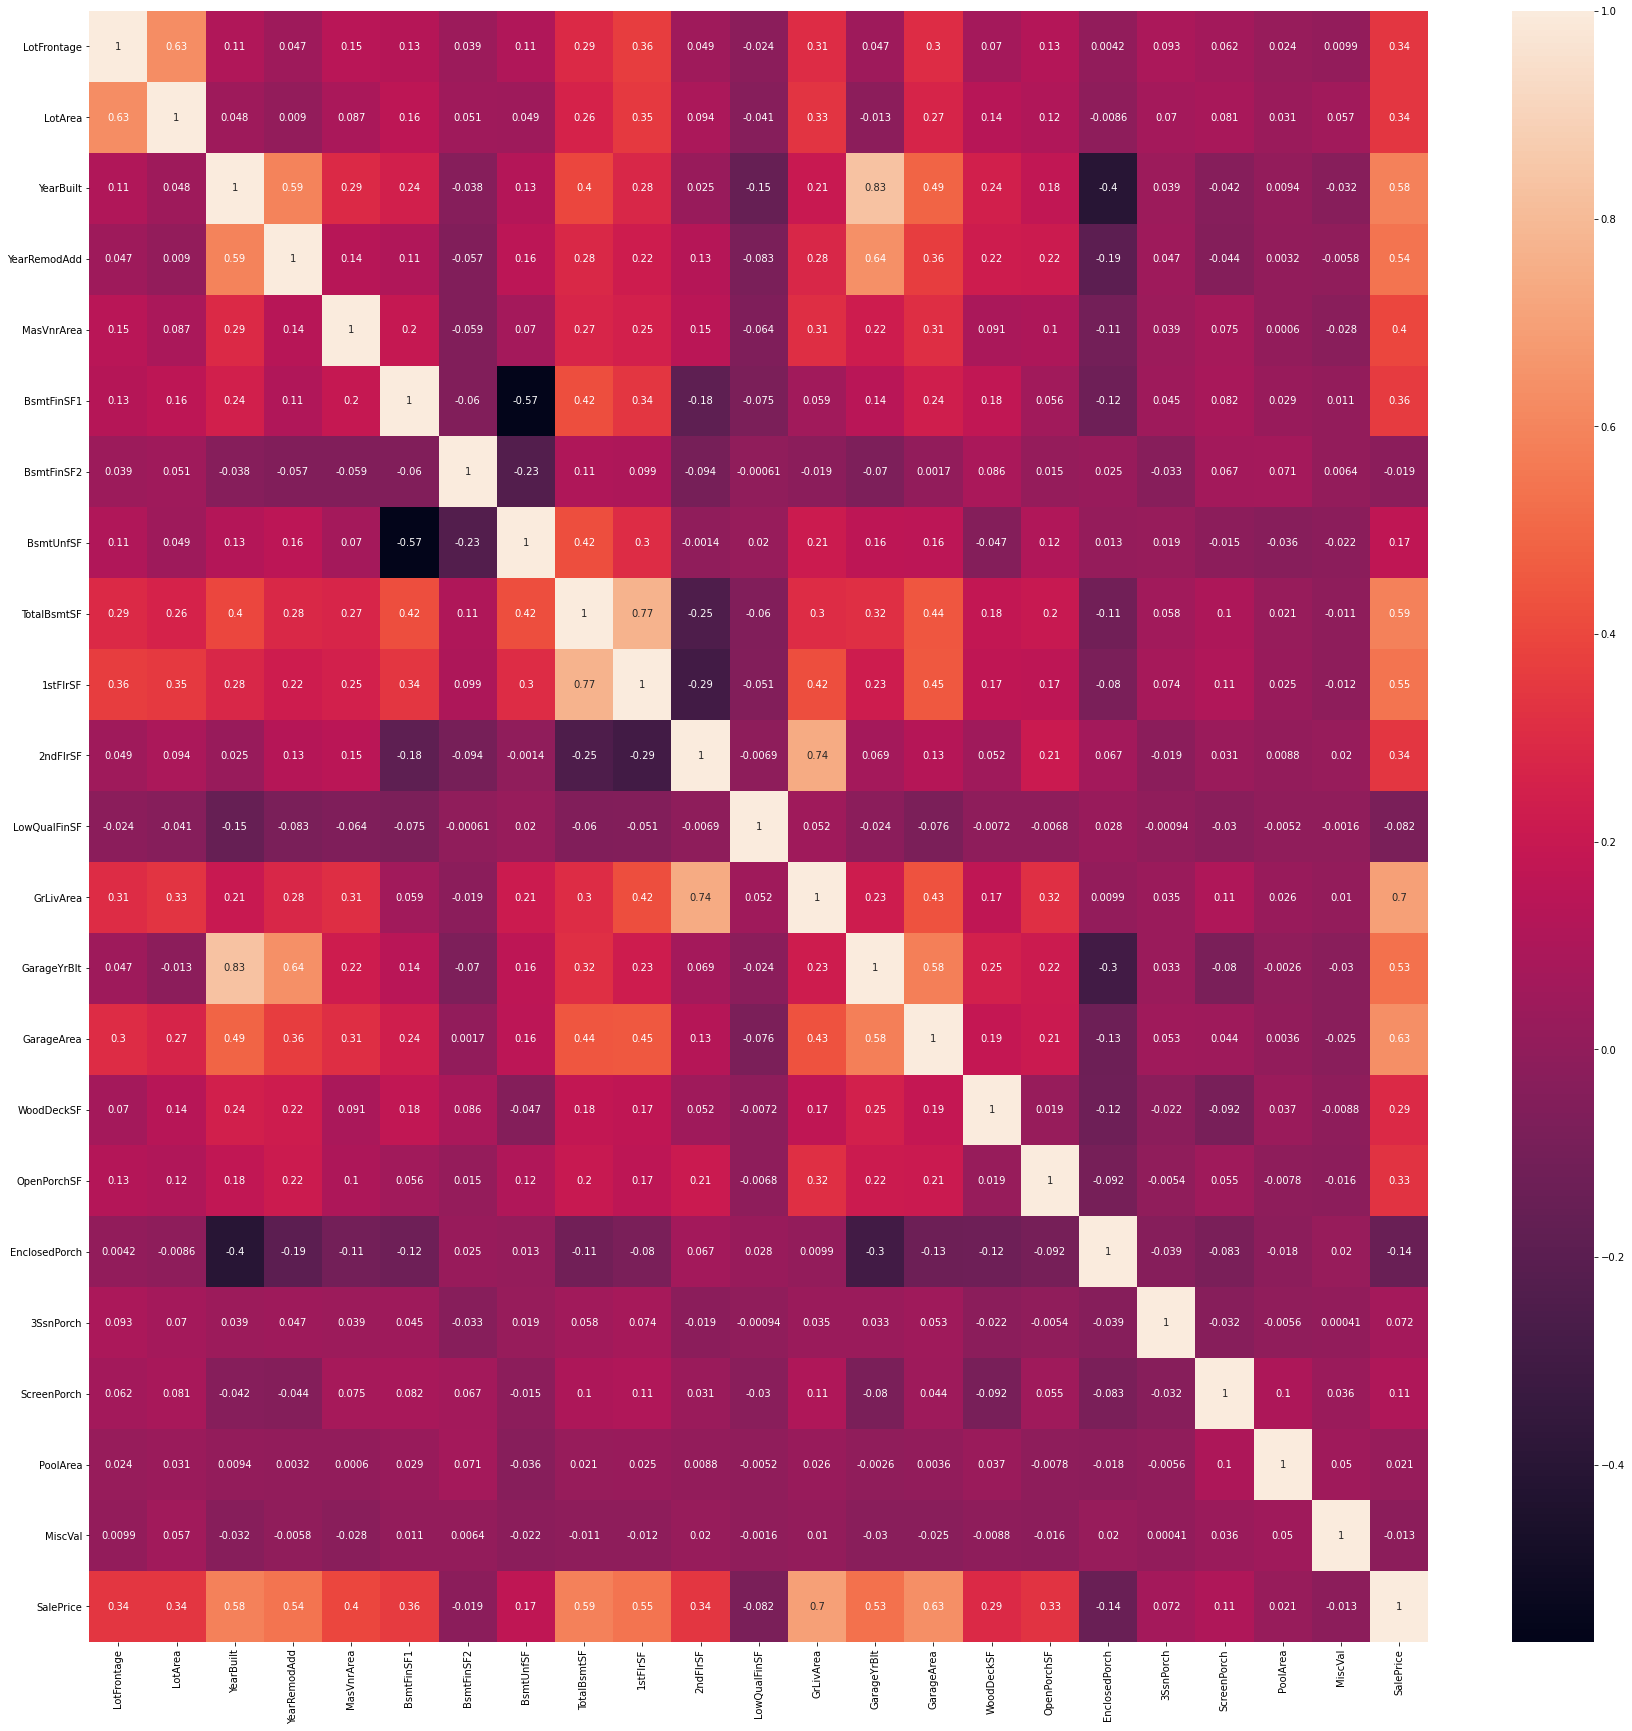

In [35]:
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(housing.corr(), 
            xticklabels=housing.corr().columns.values,
            yticklabels=housing.corr().columns.values,annot= True)

plt.show()

#### Land related features
1. LotArea
2. LotFrontage
3. LotConfig
4. LotShape
5. LandContour
6. LandSlope

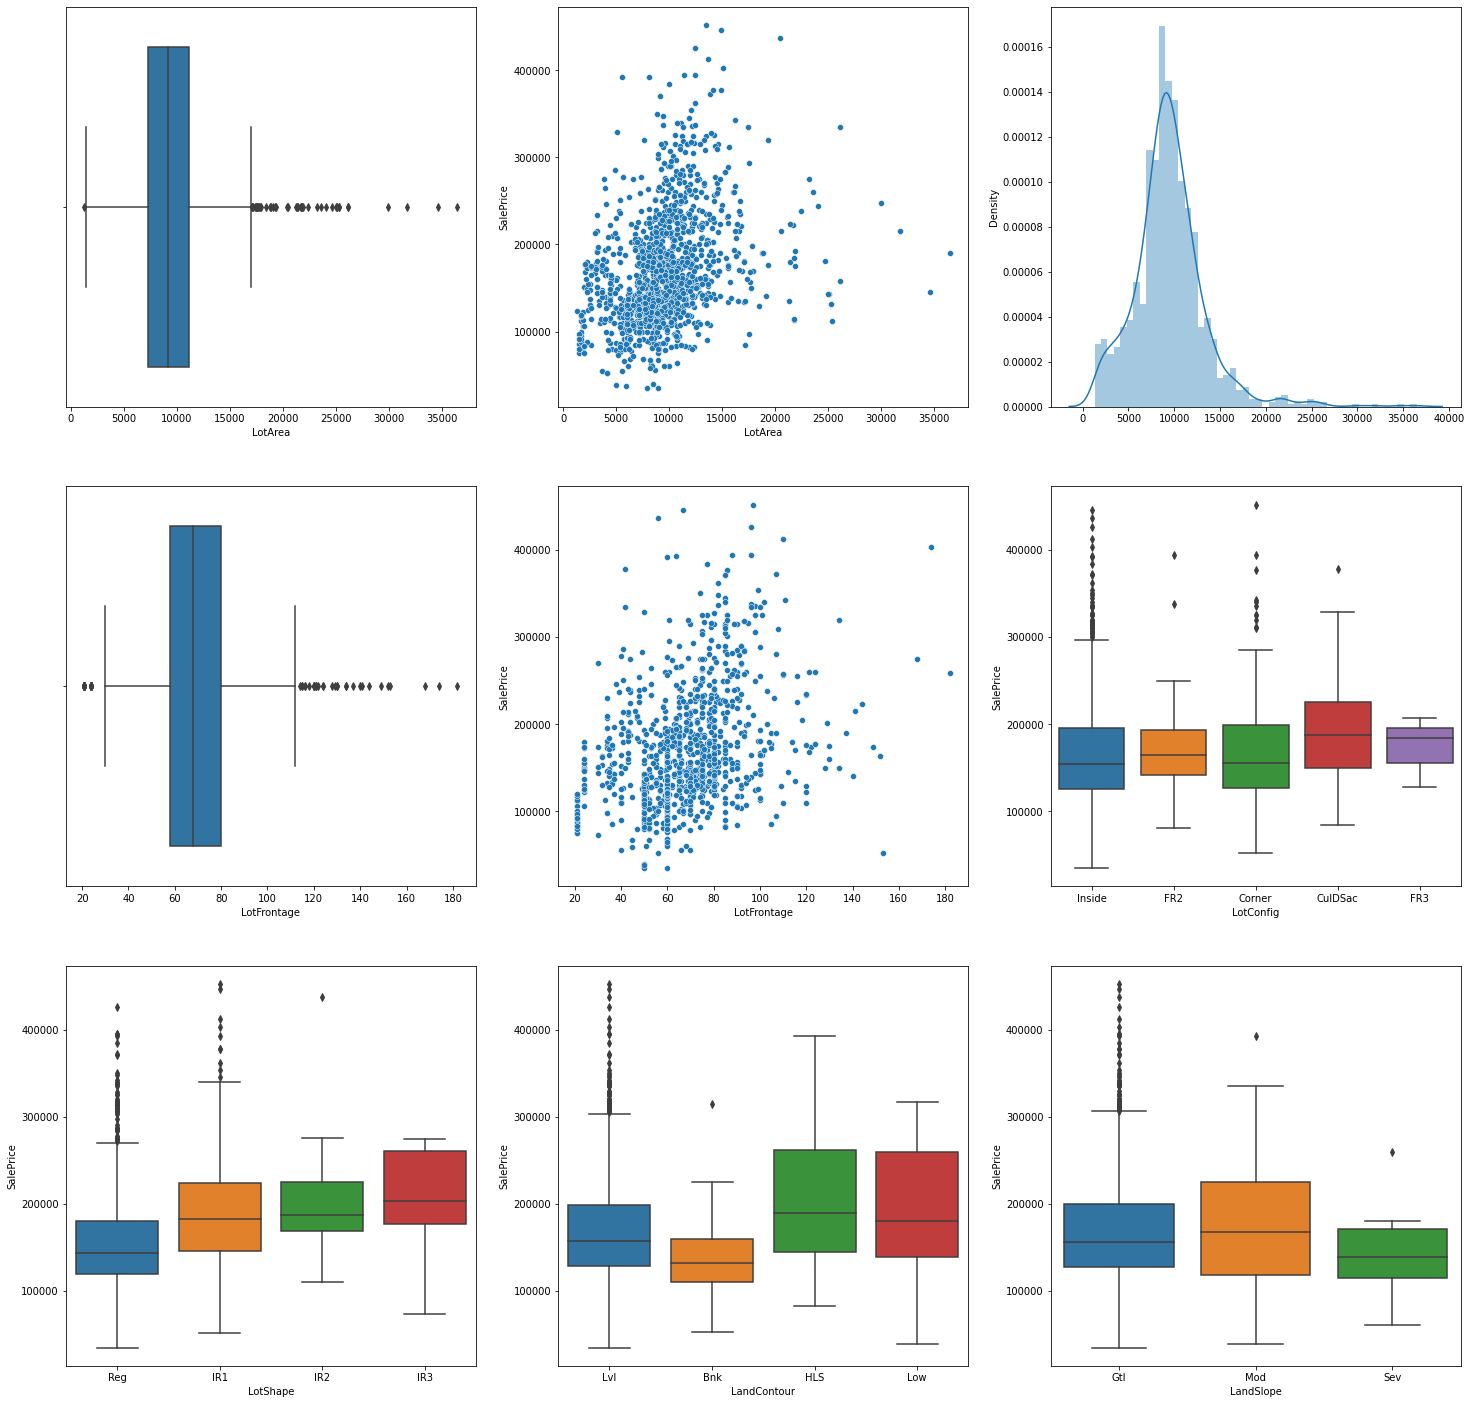

In [36]:
plt.figure(figsize=(25,25))
plt.subplot(3,3,1)
sns.boxplot(data=housing, x='LotArea')
plt.subplot(3,3,2)
sns.scatterplot(data=housing, x='LotArea', y='SalePrice')
plt.subplot(3,3,3)
sns.distplot(x=housing.LotArea)
plt.subplot(3,3,4)
sns.boxplot(data=housing, x='LotFrontage')
plt.subplot(3,3,5)
sns.scatterplot(data=housing, x='LotFrontage', y='SalePrice')
plt.subplot(3,3,6)
sns.boxplot(data=housing, x='LotConfig', y='SalePrice')
plt.subplot(3,3,7)
sns.boxplot(data=housing, x='LotShape', y='SalePrice')
plt.subplot(3,3,8)
sns.boxplot(data=housing, x='LandContour', y='SalePrice')
plt.subplot(3,3,9)
sns.boxplot(data=housing, x='LandSlope', y='SalePrice')
plt.show()

#### Observations
- Among LotShape, LandContour, LandSlope and LotConfig - LotShape has significant impact on the SalePrice
- We will convert the LotShape, LotCountour, LotSlope and LotConfig into dummy variables
- Both LotArea and LotFrontage have similar relationship with target variable. This is clear from the correlation matrix as well. We will drop one of the variables. LotFrontage is partly described by LotConfig - Inside, 2 side frontage, 3 side frontage so we will drop LotProperty.

In [37]:
#Drop LotFrontage
to_be_dropped = set()
to_be_dropped.add('LotFrontage')

In [38]:
to_dummy_variables = set()
to_dummy_variables.add('LotShape')
to_dummy_variables.add('LandContour')
to_dummy_variables.add('LandSlope')
to_dummy_variables.add('LotConfig')

#### Type and Zone of property
1. MSSubClass
2. MSZoning

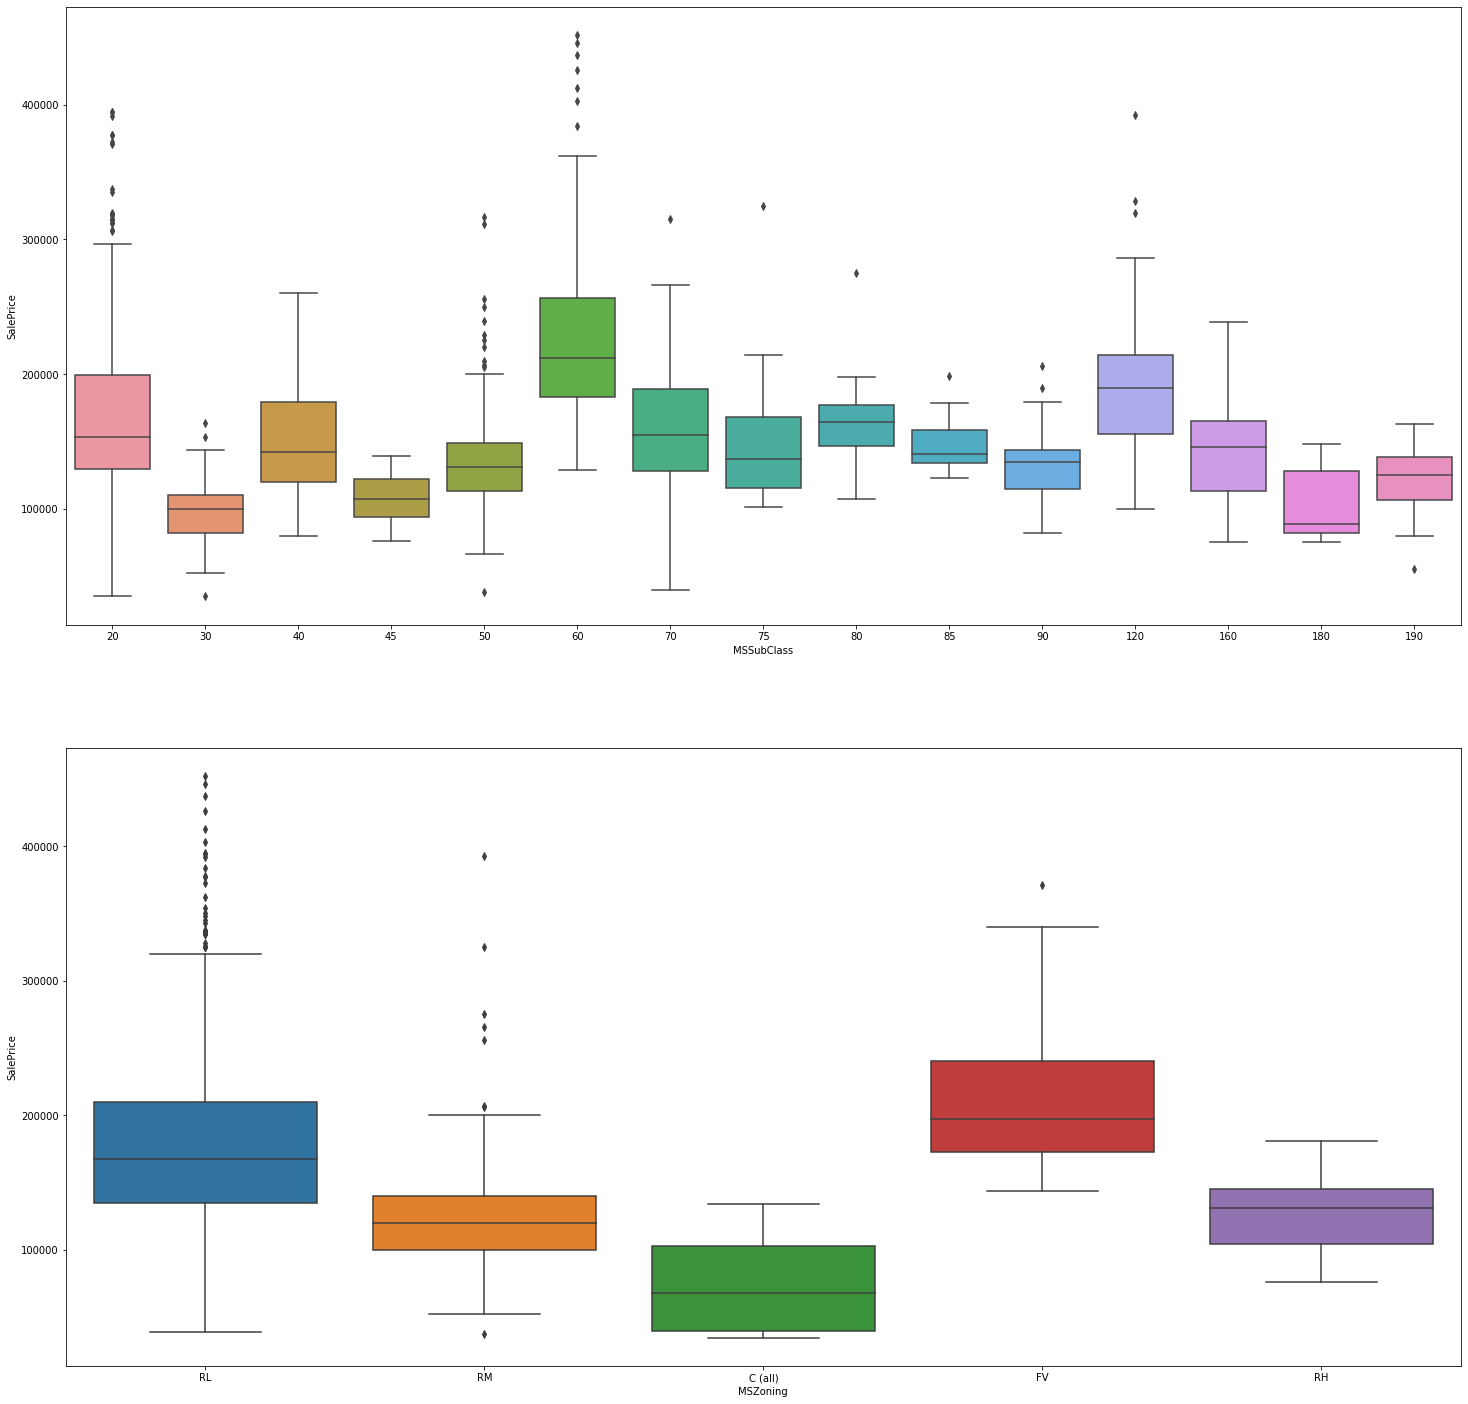

In [39]:
plt.figure(figsize=(25,25))
plt.subplot(2,1,1)
sns.boxplot(data=housing, x='MSSubClass', y='SalePrice')
plt.subplot(2,1,2)
sns.boxplot(data=housing, x='MSZoning', y='SalePrice')
plt.show()

#### Observations
- Both MSSubClass and MSZoning impact the SalePrice
- We will convert these variables to dummy variables

In [40]:
to_dummy_variables.add('MSSubClass')
to_dummy_variables.add('MSZoning')

#### Access to property
1. Street
2. PavedDrive

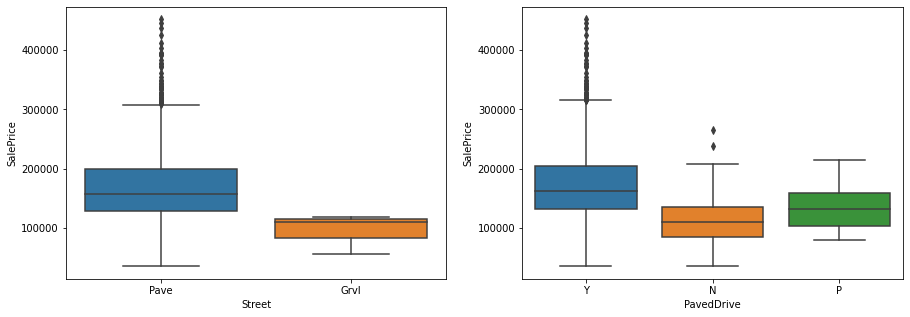

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=housing, x='Street', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='PavedDrive', y='SalePrice')
plt.show()

#### Observations
- Paved access to property from street has greater impact on the SalePrice
- Similarly both Paved Drive and Partial Paved Drive impact the SalePrice
- We will convert these variables to dummy

In [42]:
housing.Street = housing.Street.map({'Pave':1, 'Grvl':0})
to_dummy_variables.add('PavedDrive')

#### Utilities

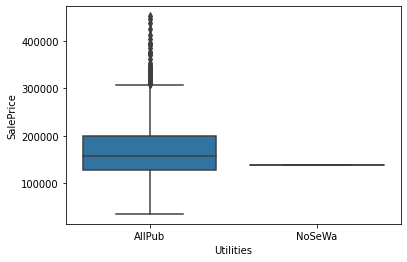

In [43]:
sns.boxplot(data=housing, x='Utilities', y='SalePrice')
plt.show()

In [44]:
housing.Utilities.value_counts()

AllPub    1333
NoSeWa       1
Name: Utilities, dtype: int64

We can drop Utilities except one record, all have same values

In [45]:
to_be_dropped.add('Utilities')

#### Neighborhood

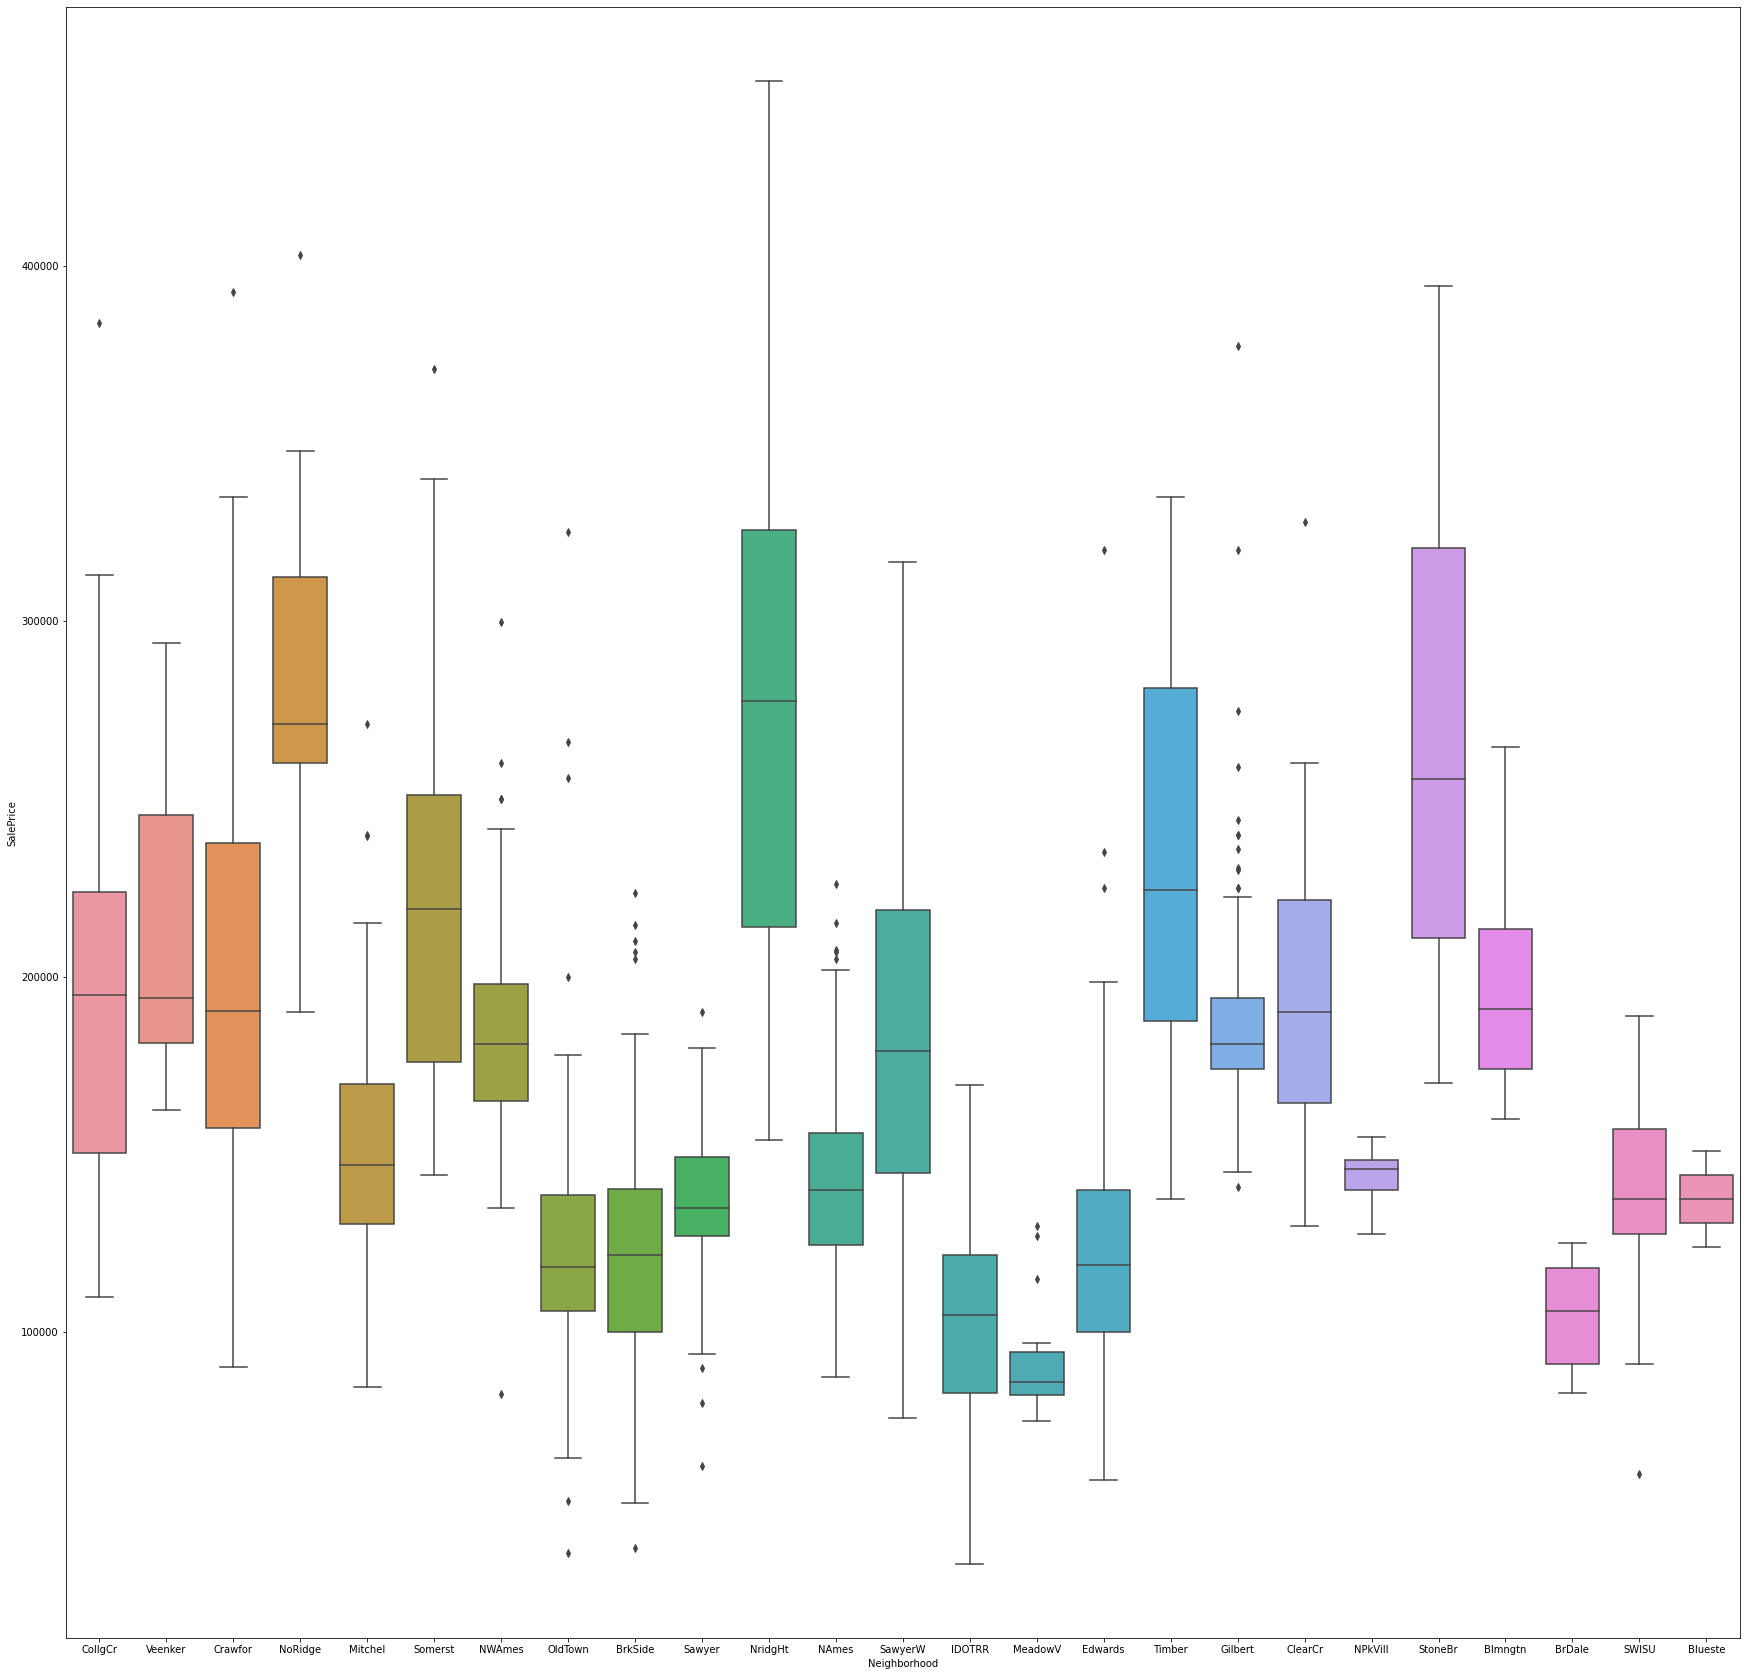

In [46]:
f, ax = plt.subplots(figsize=(30, 30))
b = sns.boxplot(data=housing, x='Neighborhood', y='SalePrice')
plt.show()
to_dummy_variables.add('Neighborhood')

#### Observation 
- Neighborhood has significant impact on the SalePrice

#### Condition of the house 
1. Condition1
2. Condition2

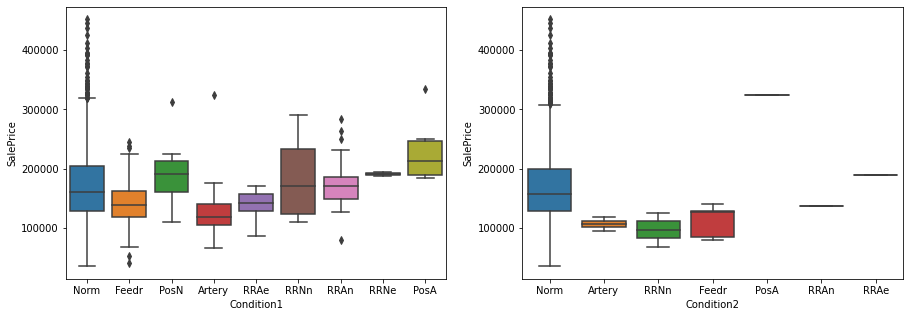

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=housing, x='Condition1', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='Condition2', y='SalePrice')
plt.show()

In [48]:
# We will convert Condition1 and Condition2 to dummy variables
to_dummy_variables.add('Condition1')
to_dummy_variables.add('Condition2')

#### BldgType and HouseStyle

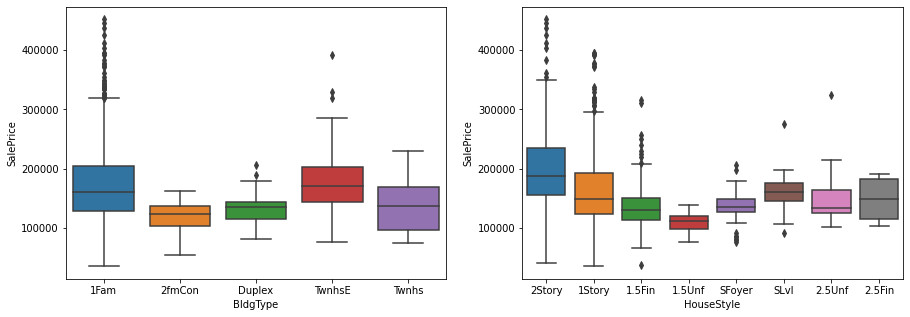

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=housing, x='BldgType', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='HouseStyle', y='SalePrice')
plt.show()

In [50]:
# We will convert BldgType and HouseStyle to dummy variables
to_dummy_variables.add('BldgType')
to_dummy_variables.add('HouseStyle')

#### OverallQual and OverallCond

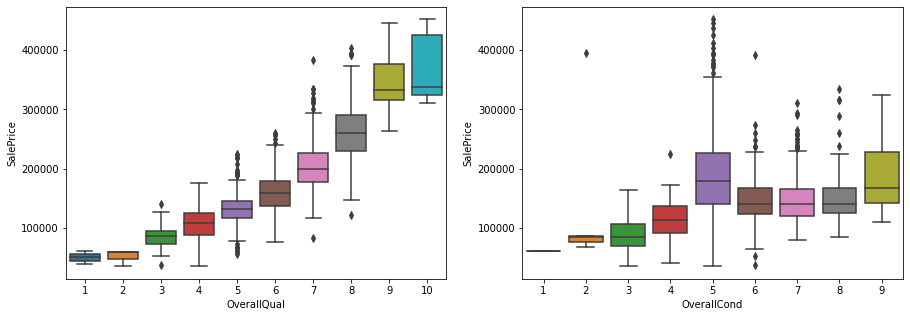

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=housing, x='OverallQual', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='OverallCond', y='SalePrice')
plt.show()

#### Observations
- OverallQual has significant impact on SalePrice
- OverallCond has some impact on SalePrice

In [52]:
to_dummy_variables.add('OverallCond')
to_dummy_variables.add('OverallQual')

#### YearBuilt and YearRemodAdd

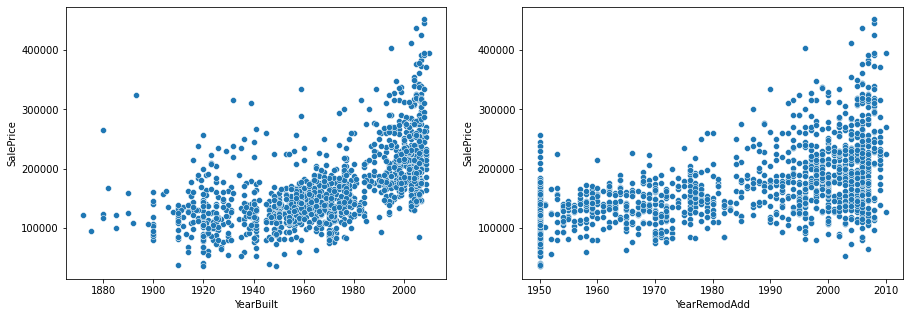

In [53]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(data=housing, x='YearBuilt', y='SalePrice')
plt.subplot(1,2,2)
sns.scatterplot(data=housing, x='YearRemodAdd', y='SalePrice')
plt.show()

#### Observations
- Relationship with target variable is very simialr for both YearBuilt and YearRemodAdd
- This is confirm by correlation matrix
- Lets drop YearRemodAdd

In [54]:
to_be_dropped.add('YearRemodAdd')

#### Roof features
1. RoofStyle
2. RoofMatl

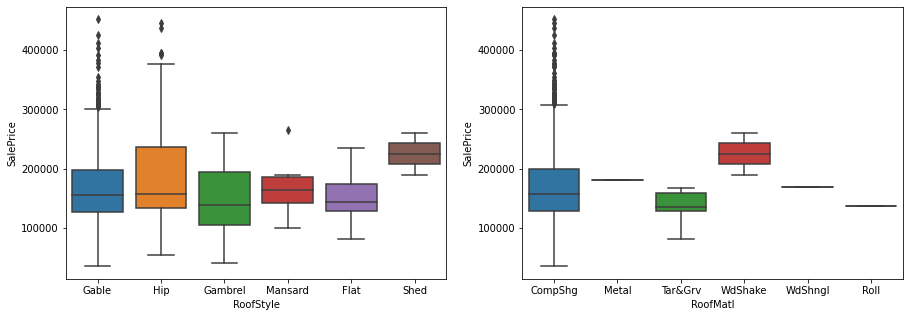

In [55]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=housing, x='RoofStyle', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='RoofMatl', y='SalePrice')
plt.show()

In [56]:
# We will convert RoofStyle and RoofMatl to dummy variables
to_dummy_variables.add('RoofStyle')
to_dummy_variables.add('RoofMatl')

#### Exterior features of the house
1. Exterior1st
2. Exterior2nd
3. ExterQual
4. ExterCond
5. MasVnrType
6. MasVnrArea
7. Foundation

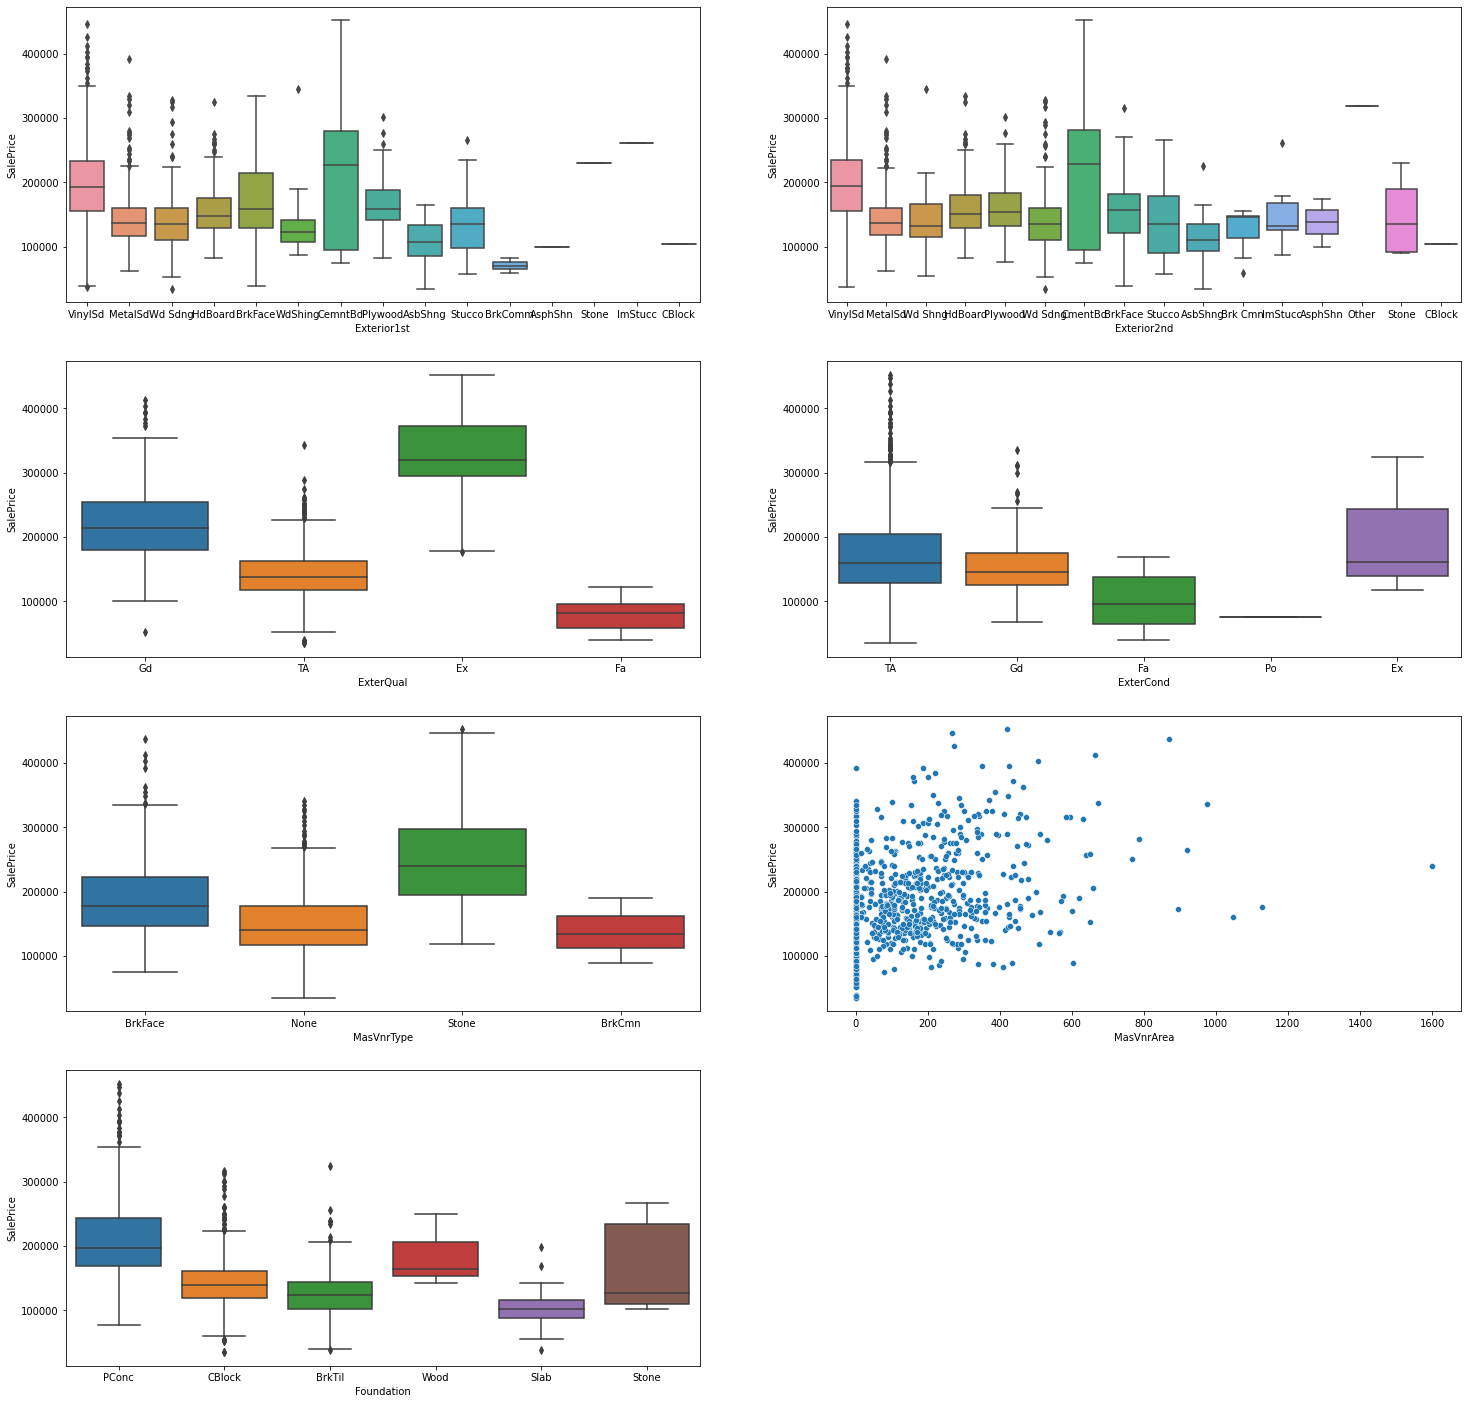

In [57]:
plt.figure(figsize=(25,25))
plt.subplot(4,2,1)
sns.boxplot(data=housing, x='Exterior1st', y='SalePrice')
plt.subplot(4,2,2)
sns.boxplot(data=housing, x='Exterior2nd', y='SalePrice')
plt.subplot(4,2,3)
sns.boxplot(data=housing, x='ExterQual', y='SalePrice')
plt.subplot(4,2,4)
sns.boxplot(data=housing, x='ExterCond', y='SalePrice')
plt.subplot(4,2,5)
sns.boxplot(data=housing, x='MasVnrType', y='SalePrice')
plt.subplot(4,2,6)
sns.scatterplot(data=housing, x='MasVnrArea', y='SalePrice')
plt.subplot(4,2,7)
sns.boxplot(data=housing, x='Foundation', y='SalePrice')
plt.show()

#### Observations
- Some values of Exterior1st and Exterior2nd variables have significant impact on the SalePrice
- SalePrice is highest for ExterQual Excellent followed by Good condition
- The sale prices are high for houses with Excelent ExterCond
- Houses with Stone MasVnrType fetch highest price
- MasVnrArea shows some linear relationship with target variable, however many values are 0 and large number of values form cluster aroud 200. We can drop the variable.
- Houses with poured concrete foundation have highest sale price 

In [58]:
to_dummy_variables.add('Exterior1st')
to_dummy_variables.add('Exterior2nd')
to_dummy_variables.add('ExterQual')
to_dummy_variables.add('ExterCond')
to_dummy_variables.add('MasVnrType')
to_dummy_variables.add('Foundation')
to_be_dropped.add('MasVnrArea')

#### Basement features of the house
1. BsmtQual
2. BsmtCond
3. BsmtExposure
4. BsmtFinType1
5. BsmtFinSF1
6. BsmtFinType2
7. BsmtFinSF2
8. BsmtUnfSF
9. TotalBsmtSF

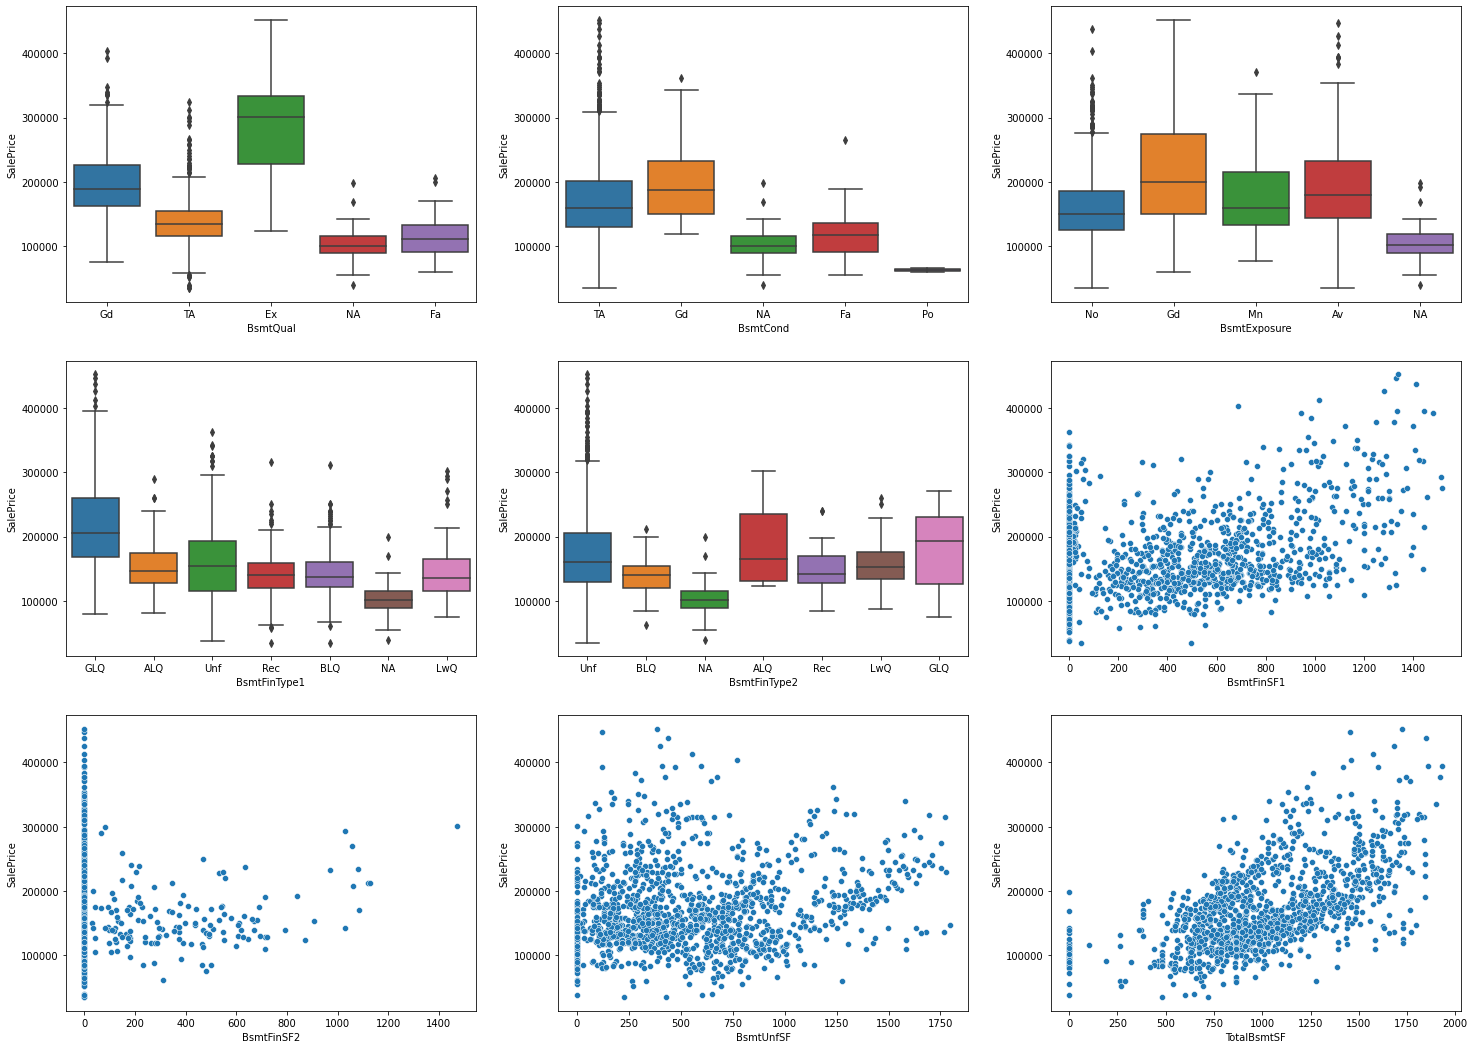

In [59]:
plt.figure(figsize=(25,25))
plt.subplot(4,3,1)
sns.boxplot(data=housing, x='BsmtQual', y='SalePrice')
plt.subplot(4,3,2)
sns.boxplot(data=housing, x='BsmtCond', y='SalePrice')
plt.subplot(4,3,3)
sns.boxplot(data=housing, x='BsmtExposure', y='SalePrice')
plt.subplot(4,3,4)
sns.boxplot(data=housing, x='BsmtFinType1', y='SalePrice')
plt.subplot(4,3,5)
sns.boxplot(data=housing, x='BsmtFinType2', y='SalePrice')
plt.subplot(4,3,6)
sns.scatterplot(data=housing, x='BsmtFinSF1', y='SalePrice')
plt.subplot(4,3,7)
sns.scatterplot(data=housing, x='BsmtFinSF2', y='SalePrice')
plt.subplot(4,3,8)
sns.scatterplot(data=housing, x='BsmtUnfSF', y='SalePrice')
plt.subplot(4,3,9)
sns.scatterplot(data=housing, x='TotalBsmtSF', y='SalePrice')
plt.show()

#### Observations
- Some values of BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 features have decent impact on the sale price
- Zero value of BsmtFinSF1, BsmtFinSF2 and BsmtUnfSF cover almost all the SalePrice range, it means this variable does not have significant impact on the SalePrice and are explained better by BsmtFinType1 and BsmtFinType2. We will drop these variables.
- TotalBsmtSF has clear linear relationship with the SalePrice. 

In [60]:
to_dummy_variables.add('BsmtQual')
to_dummy_variables.add('BsmtCond')
to_dummy_variables.add('BsmtExposure')
to_dummy_variables.add('BsmtFinType1')
to_dummy_variables.add('BsmtFinType2')
to_be_dropped.add('BsmtFinSF1')
to_be_dropped.add('BsmtFinSF2')
to_be_dropped.add('BsmtUnfSF')

#### Heating system and Electrical features of the house
1. Heating
2. HeatingQC
3. CentralAir
4. Electrical

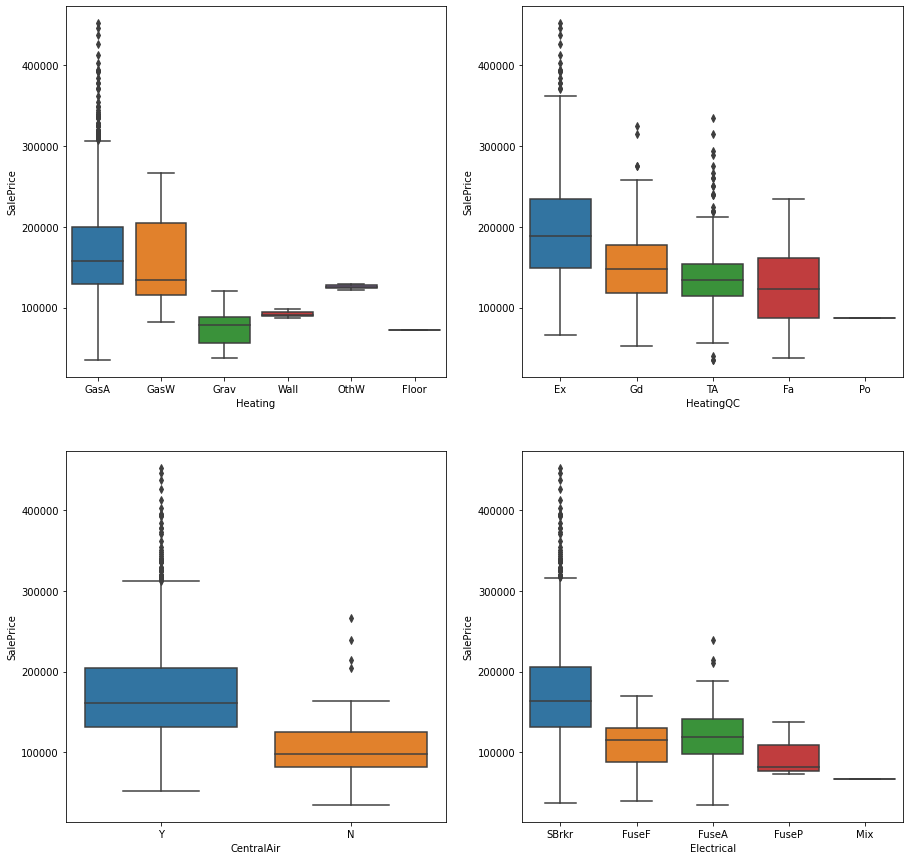

In [61]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.boxplot(data=housing, x='Heating', y='SalePrice')
plt.subplot(2,2,2)
sns.boxplot(data=housing, x='HeatingQC', y='SalePrice')
plt.subplot(2,2,3)
sns.boxplot(data=housing, x='CentralAir', y='SalePrice')
plt.subplot(2,2,4)
sns.boxplot(data=housing, x='Electrical', y='SalePrice')
plt.show()

#### Observations
- All these variables have some impact on the SalePrice

In [62]:
to_dummy_variables.add('Heating')
to_dummy_variables.add('HeatingQC')
to_dummy_variables.add('Electrical')
housing.CentralAir = housing.CentralAir.map({'Y':1, 'N':0})

#### Living spaces related features
1. 1stFlrSF
2. 2ndFlrSF
3. LowQualFinSF
4. GrLivArea
5. BsmtFullBath
6. BsmtHalfBath
7. FullBath
8. HalfBath
9. BedroomAbvGr
10. KitchenAbvGr
11. KitchenQual
12. TotRmsAbvGrd

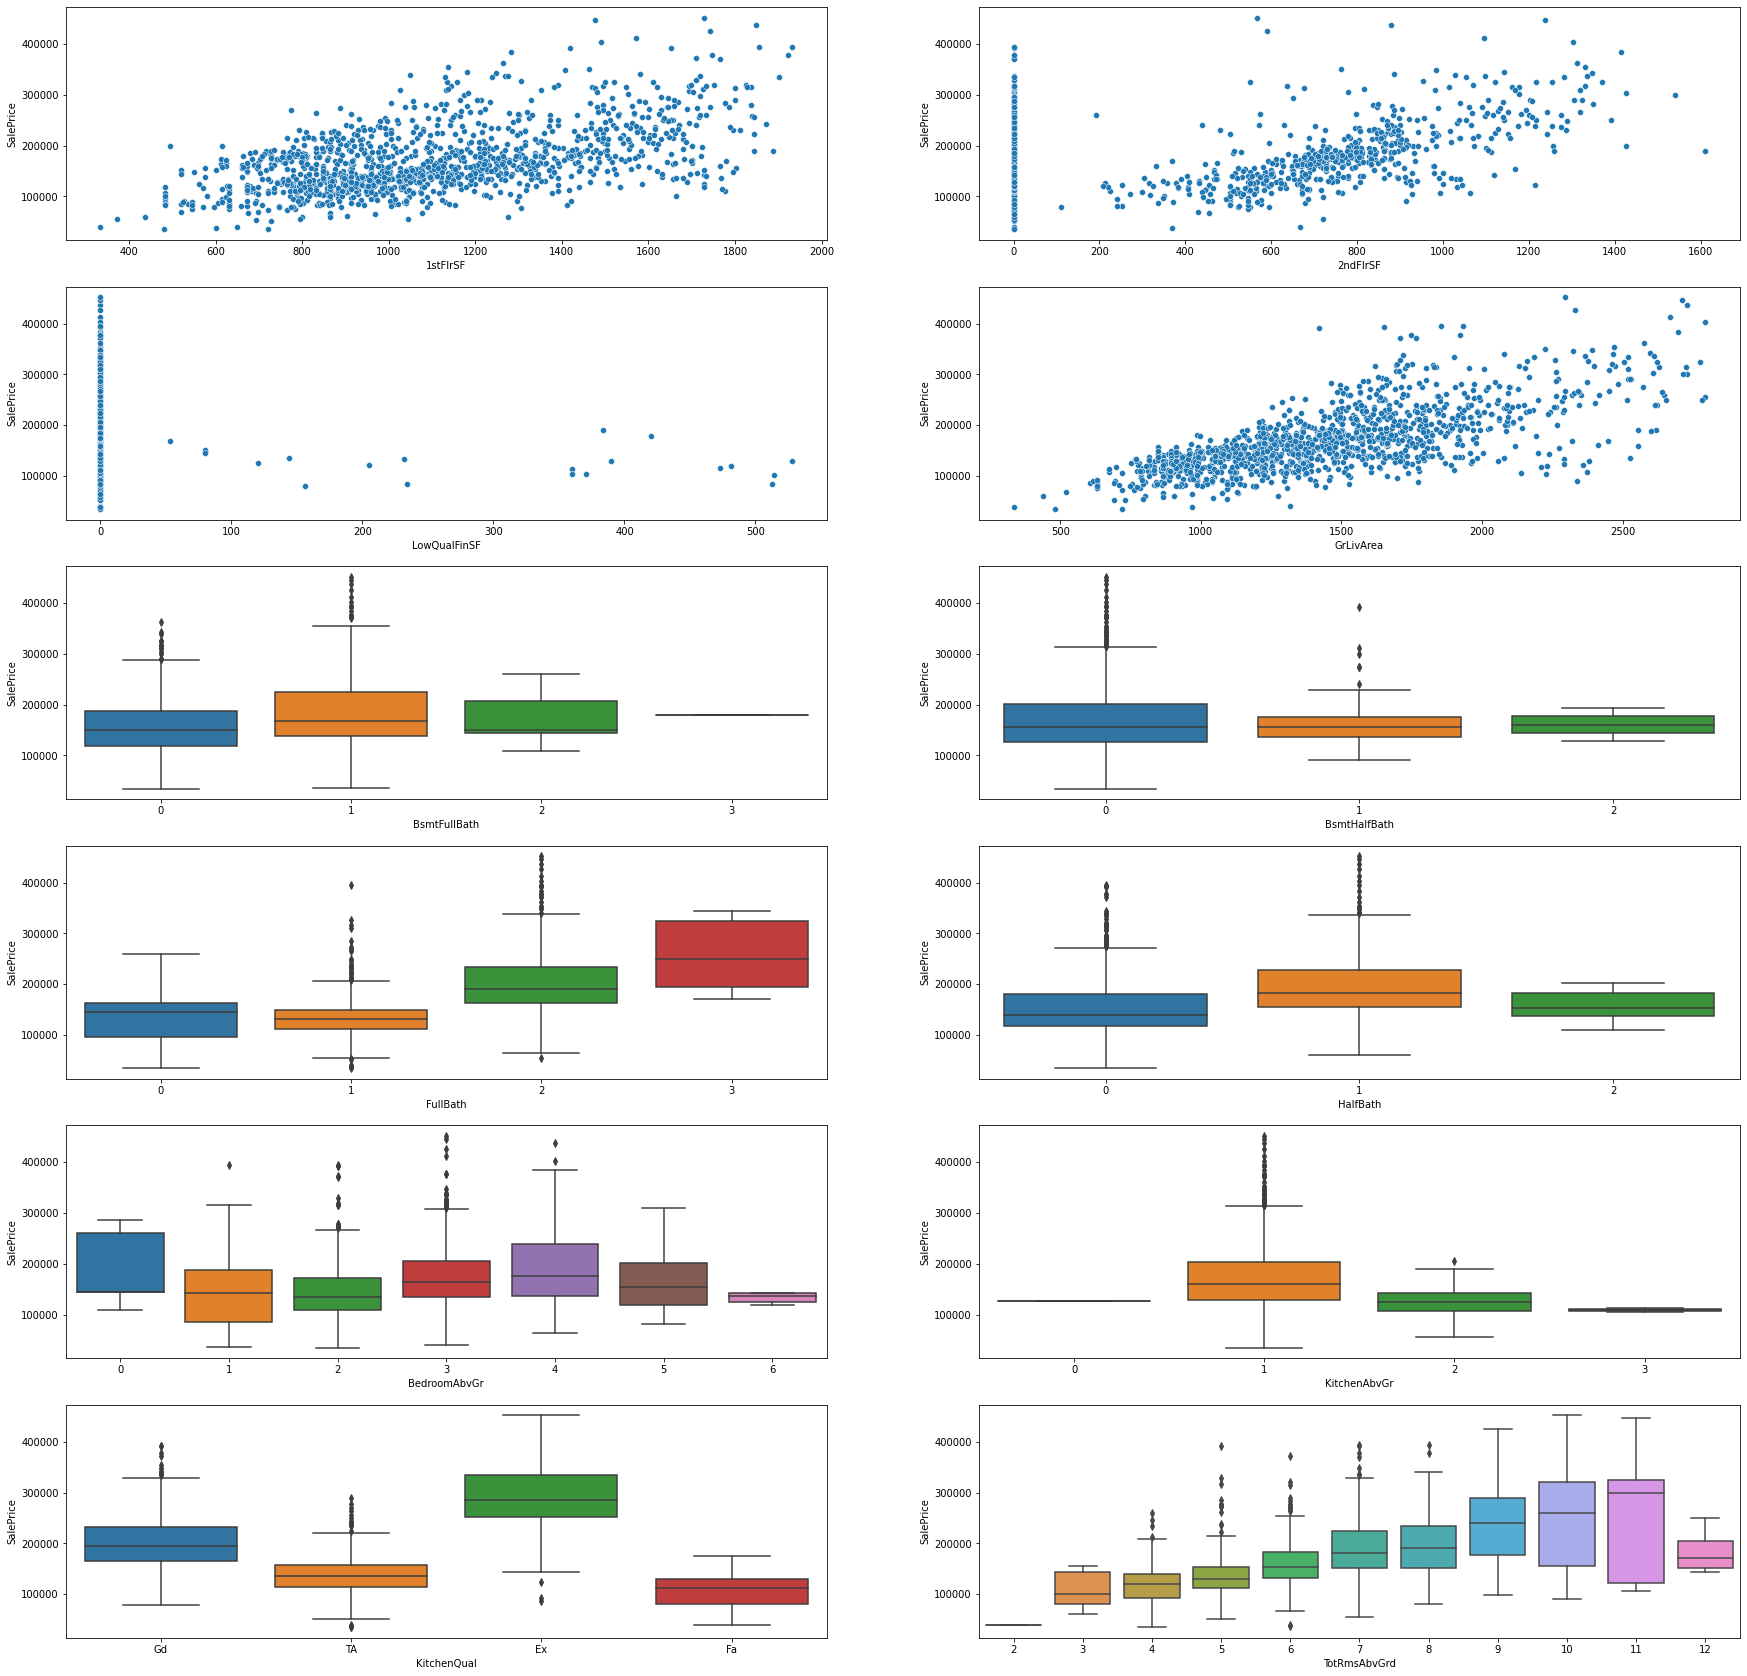

In [63]:
plt.figure(figsize=(30,30))
plt.subplot(6,2,1)
sns.scatterplot(data=housing, x='1stFlrSF', y='SalePrice')
plt.subplot(6,2,2)
sns.scatterplot(data=housing, x='2ndFlrSF', y='SalePrice')
plt.subplot(6,2,3)
sns.scatterplot(data=housing, x='LowQualFinSF', y='SalePrice')
plt.subplot(6,2,4)
sns.scatterplot(data=housing, x='GrLivArea', y='SalePrice')
plt.subplot(6,2,5)
sns.boxplot(data=housing, x='BsmtFullBath', y='SalePrice')
plt.subplot(6,2,6)
sns.boxplot(data=housing, x='BsmtHalfBath', y='SalePrice')
plt.subplot(6,2,7)
sns.boxplot(data=housing, x='FullBath', y='SalePrice')
plt.subplot(6,2,8)
sns.boxplot(data=housing, x='HalfBath', y='SalePrice')
plt.subplot(6,2,9)
sns.boxplot(data=housing, x='BedroomAbvGr', y='SalePrice')
plt.subplot(6,2,10)
sns.boxplot(data=housing, x='KitchenAbvGr', y='SalePrice')
plt.subplot(6,2,11)
sns.boxplot(data=housing, x='KitchenQual', y='SalePrice')
plt.subplot(6,2,12)
sns.boxplot(data=housing, x='TotRmsAbvGrd', y='SalePrice')
plt.show()

#### Observations
- 1stFlrSF and GrLivArea have positive relationship with SalePrice
- 2ndFlrSF and LowQualFinSF have many 0 values which covers the entire range of SalePrice. We can drop these columns.
- KitchenQual and TotRmsAbvGrd have significant impact on the SalePrice
- FullBath has good impact on SalePrice as compared to HalfBath. We can drop HalfBath.
- Between BsmtFullBath and BsmtHalfBath, we can drop BsmtHalfBath

In [64]:
to_dummy_variables.add('KitchenQual')
to_dummy_variables.add('BsmtFullBath')
to_dummy_variables.add('BsmtHalfBath')
to_dummy_variables.add('FullBath')
to_dummy_variables.add('HalfBath')
to_dummy_variables.add('BedroomAbvGr')
to_dummy_variables.add('KitchenAbvGr')
to_dummy_variables.add('TotRmsAbvGrd')
to_be_dropped.add('2ndFlrSF')
to_be_dropped.add('LowQualFinSF')

#### Home functionality

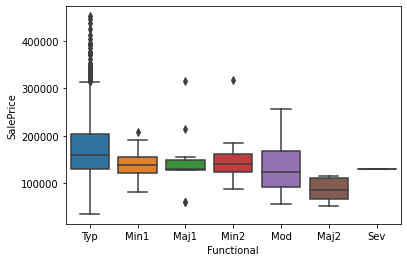

In [65]:
sns.boxplot(data=housing, x='Functional', y='SalePrice')
plt.show()

#### Observations
- Though median values are similar for some functionalities of the house, Typical, Moderate deductions and Major deductions have greater impact on the prices.

In [66]:
to_dummy_variables.add('Functional')

#### Fireplace related features
1. Fireplaces
2. FireplaceQu

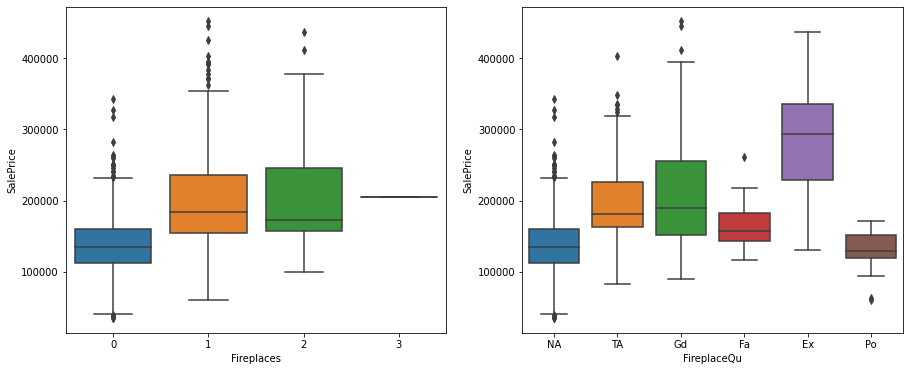

In [67]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(data=housing, x='Fireplaces', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='FireplaceQu', y='SalePrice')
plt.show()

#### Observations
- Number of Fireplaces has significant impact on the SalePrice
- The quality of Fireplaces impact the SalePrices as well

In [68]:
to_dummy_variables.add('FireplaceQu')
to_dummy_variables.add('Fireplaces')

#### Garage related features of the house
1. GarageType
2. GarageYrBlt
3. GarageFinish
4. GarageCars
5. GarageArea
6. GarageQual
7. GarageCond

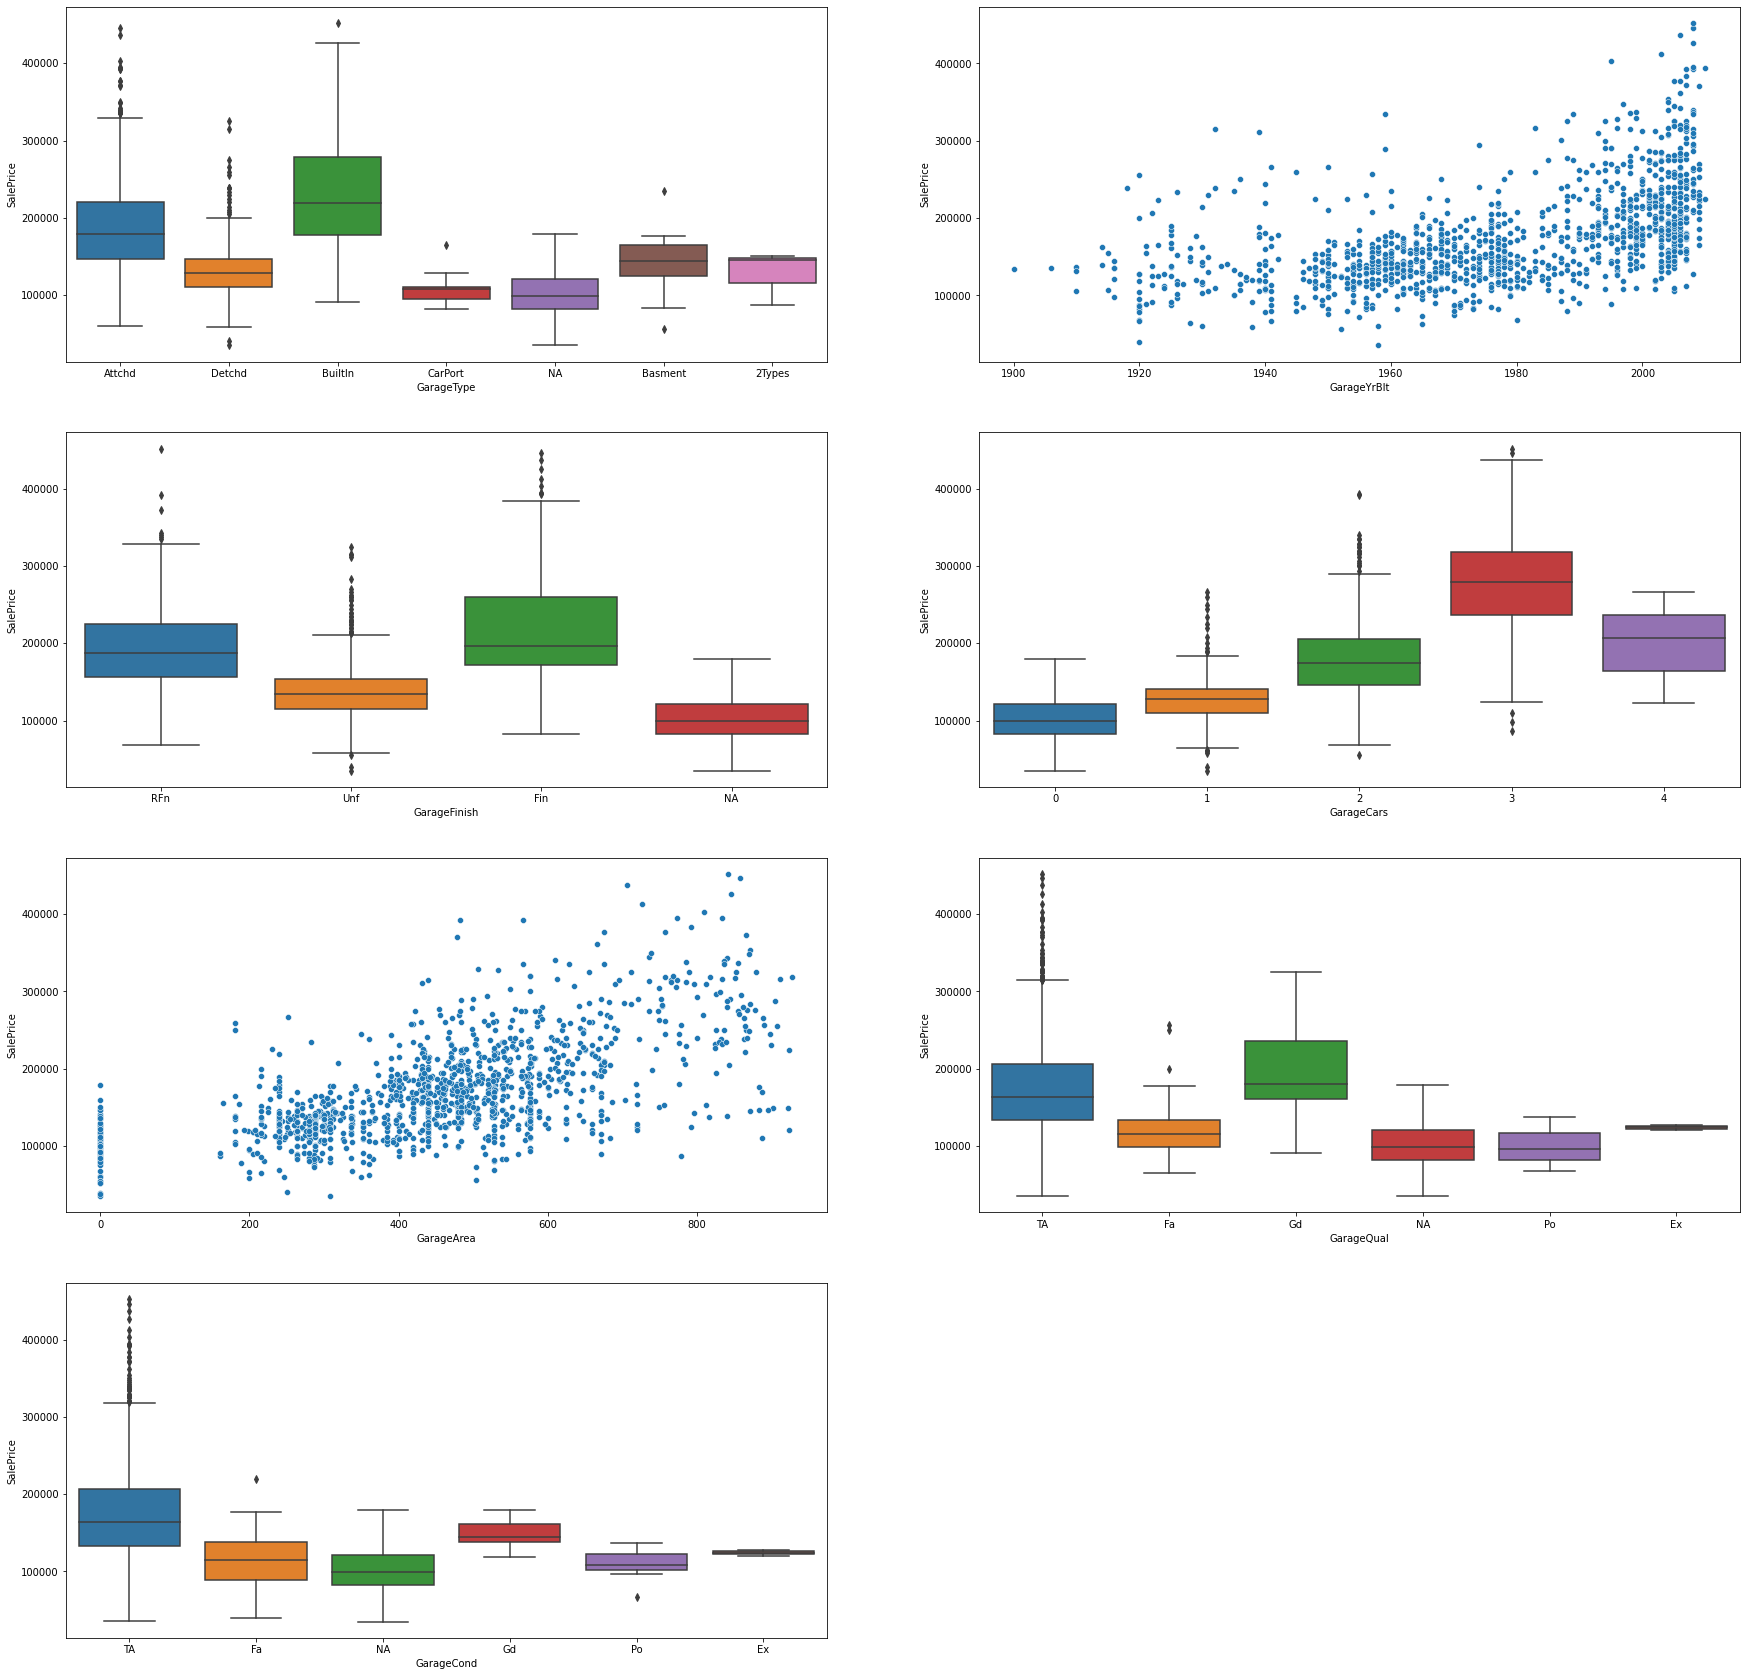

In [69]:
plt.figure(figsize=(30,30))
plt.subplot(4,2,1)
sns.boxplot(data=housing, x='GarageType', y='SalePrice')
plt.subplot(4,2,2)
sns.scatterplot(data=housing, x='GarageYrBlt', y='SalePrice')
plt.subplot(4,2,3)
sns.boxplot(data=housing, x='GarageFinish', y='SalePrice')
plt.subplot(4,2,4)
sns.boxplot(data=housing, x='GarageCars', y='SalePrice')
plt.subplot(4,2,5)
sns.scatterplot(data=housing, x='GarageArea', y='SalePrice')
plt.subplot(4,2,6)
sns.boxplot(data=housing, x='GarageQual', y='SalePrice')
plt.subplot(4,2,7)
sns.boxplot(data=housing, x='GarageCond', y='SalePrice')
plt.show()

#### Observations
- GarageType, GarageYrBlt, GarageFinish, GarageCars and GarageArea have some impact on SalePrice
- GarageQual and GarageCond have similar impact on SalePrice, we can drop one of these features.

In [70]:
to_dummy_variables.add('GarageType')
to_dummy_variables.add('GarageFinish')
to_dummy_variables.add('GarageCars')
to_dummy_variables.add('GarageCond')
to_be_dropped.add('GarageQual')

#### Porch and Deck related features
1. WoodDeckSF
2. OpenPorchSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch

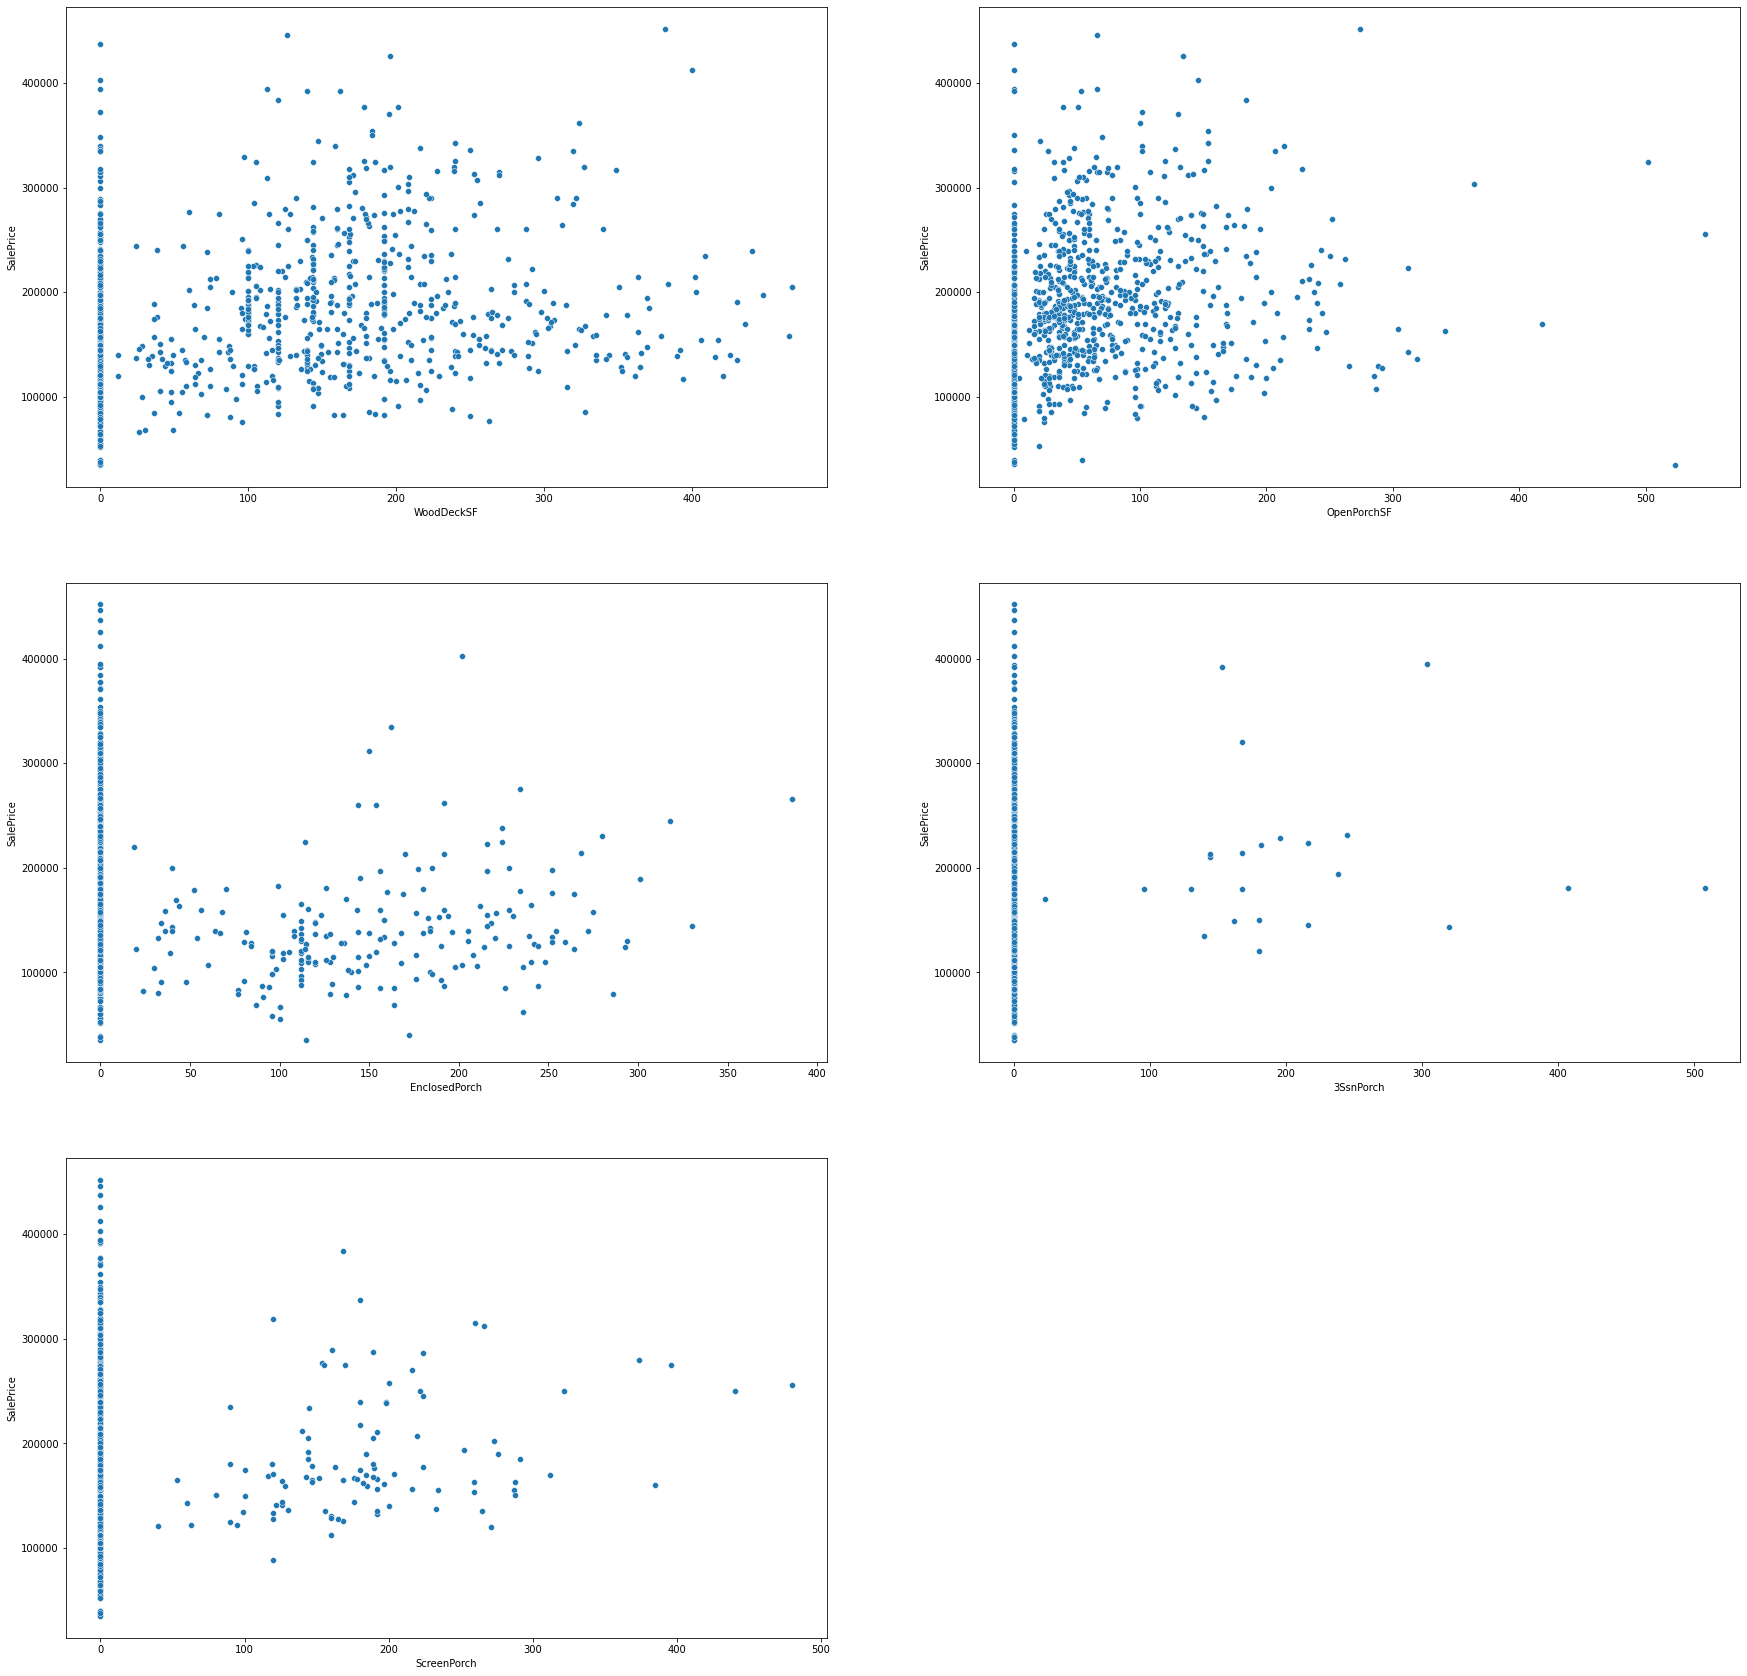

In [71]:
plt.figure(figsize=(30,30))
plt.subplot(3,2,1)
sns.scatterplot(data=housing, x='WoodDeckSF', y='SalePrice')
plt.subplot(3,2,2)
sns.scatterplot(data=housing, x='OpenPorchSF', y='SalePrice')
plt.subplot(3,2,3)
sns.scatterplot(data=housing, x='EnclosedPorch', y='SalePrice')
plt.subplot(3,2,4)
sns.scatterplot(data=housing, x='3SsnPorch', y='SalePrice')
plt.subplot(3,2,5)
sns.scatterplot(data=housing, x='ScreenPorch', y='SalePrice')
plt.show()

#### Observations
- WoodDeckSF, OpenPorchSF show impact on the SalePrice
- For EnclosedPorch, many values are zero and very few values show little impacy on the SalePrice. We can drop this variable.
- 3SsnPorch and ScreenPorch also have many values as zero and show very little impact on the SalePrice, we can drop these variables.

In [72]:
to_be_dropped.add('EnclosedPorch')
to_be_dropped.add('3SsnPorch')
to_be_dropped.add('ScreenPorch')

#### Pool related features
1. PoolArea
2. PoolQC

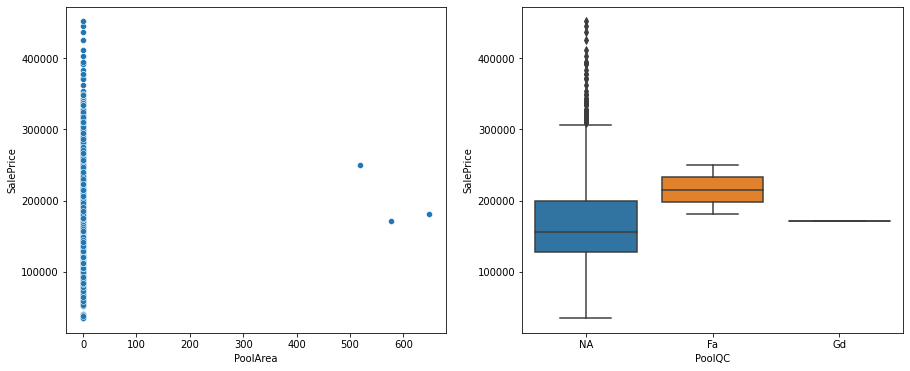

In [73]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(data=housing, x='PoolArea', y='SalePrice')
plt.subplot(1,2,2)
sns.boxplot(data=housing, x='PoolQC', y='SalePrice')
plt.show()

#### Observations
- We can drop PoolArea as PoolQC is better feature to describe the SalePrice

In [74]:
to_be_dropped.add('PoolArea')
to_dummy_variables.add('PoolQC')

#### Miscellaneous and Sale related features
1. MiscVal
2. MoSold
3. YrSold
4. SaleType
5. SaleCondition

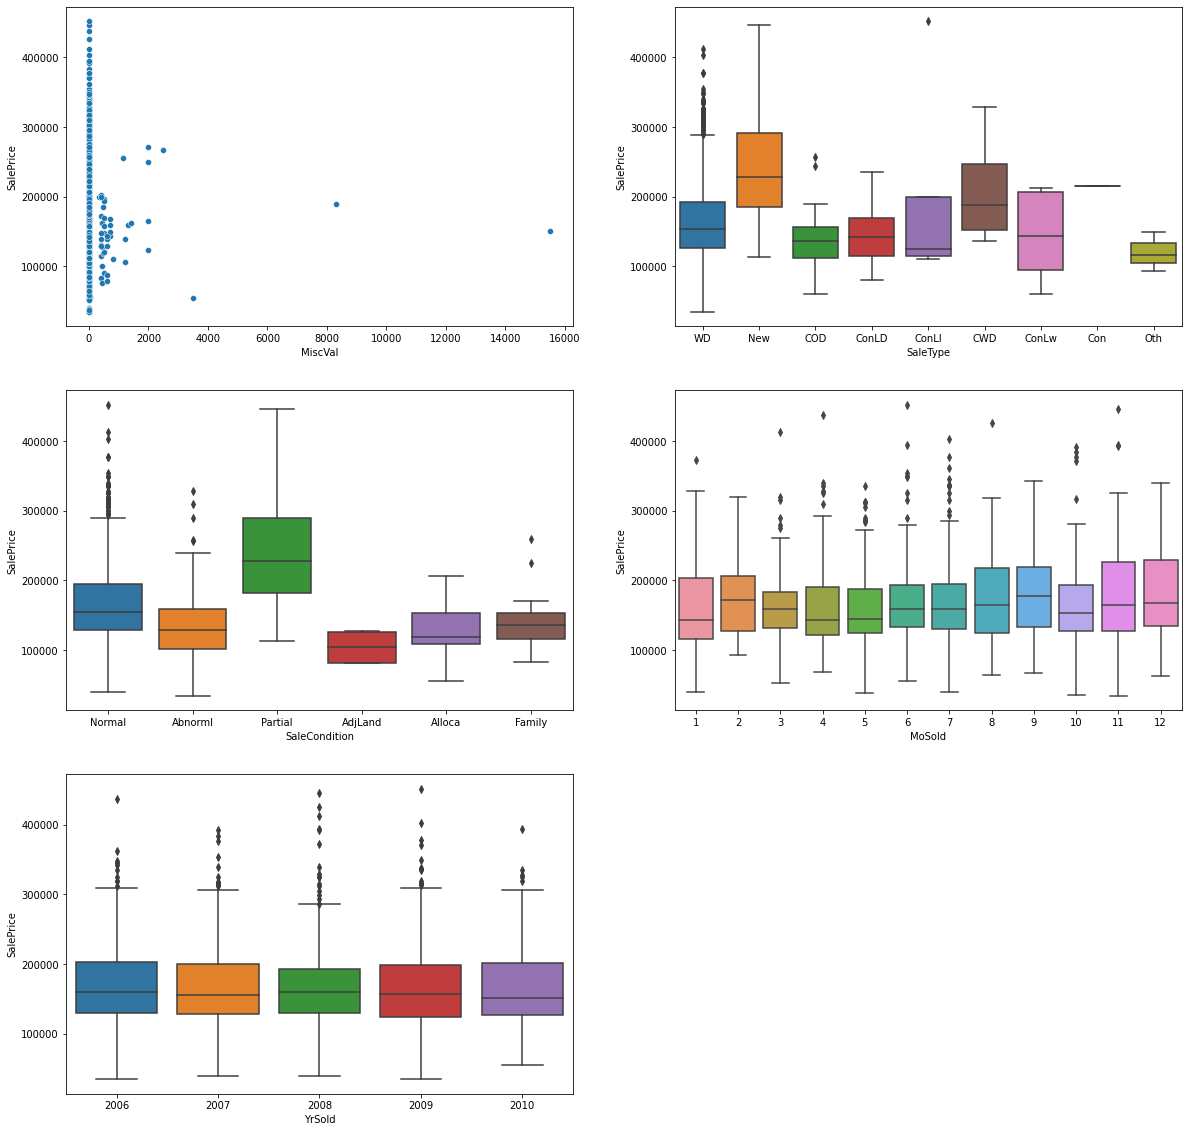

In [75]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
sns.scatterplot(data=housing, x='MiscVal', y='SalePrice')
plt.subplot(3,2,2)
sns.boxplot(data=housing, x='SaleType', y='SalePrice')
plt.subplot(3,2,3)
sns.boxplot(data=housing, x='SaleCondition', y='SalePrice')
plt.subplot(3,2,4)
sns.boxplot(data=housing, x='MoSold', y='SalePrice')
plt.subplot(3,2,5)
sns.boxplot(data=housing, x='YrSold', y='SalePrice')
plt.show()

#### Observations
- MiscVal, MoSold and YrSold does not have impact on SalePrice. We can drop this feature.
- SaleType and SaleCondition have some impact on the SalePrice.

In [76]:
to_be_dropped.add('MiscVal')
to_be_dropped.add('MoSold')
to_be_dropped.add('YrSold')
to_dummy_variables.add('SaleType')
to_dummy_variables.add('SaleCondition')

# 3. Data Preperation
1. Drop unnecessary variables
2. Data transformation and feature engineering
3. Create dummy variables
4. Train/Test Split
5. Impute missing values
6. Scale variables

## 1. Drop unnecessary variables

In [77]:
to_be_dropped

{'2ndFlrSF',
 '3SsnPorch',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'EnclosedPorch',
 'GarageQual',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'PoolArea',
 'ScreenPorch',
 'Utilities',
 'YearRemodAdd',
 'YrSold'}

In [78]:
housing.drop(columns=to_be_dropped, axis=1, inplace=True)

In [79]:
housing.shape

(1334, 60)

## 2. Data transformation and Feature Engineering

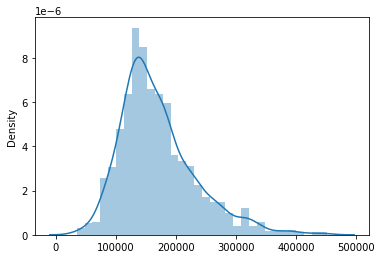

In [80]:
sns.distplot(x=housing.SalePrice)
plt.show()

- The dependent variable is not normally distributed. Towards right it has longer tail. 

In [81]:
housing.SalePrice = np.log(housing.SalePrice)

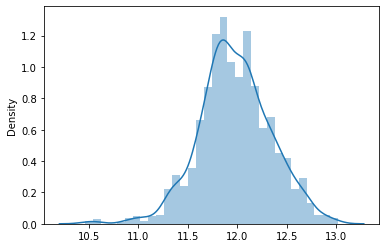

In [82]:
sns.distplot(x=housing.SalePrice)
plt.show()

Now the target variable looks normally distributed. 

In [83]:
housing['YearBuilt'] = housing.YearBuilt.max() - housing.YearBuilt

## 3. Dummy variables

In [84]:
to_dummy_variables = list(to_dummy_variables)
to_dummy_variables

['LandContour',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'MSZoning',
 'Functional',
 'MSSubClass',
 'HouseStyle',
 'ExterCond',
 'SaleType',
 'Condition1',
 'Fireplaces',
 'HalfBath',
 'SaleCondition',
 'GarageCond',
 'BsmtQual',
 'Electrical',
 'LotShape',
 'KitchenAbvGr',
 'Condition2',
 'GarageCars',
 'Exterior2nd',
 'BsmtFinType2',
 'BldgType',
 'Exterior1st',
 'HeatingQC',
 'GarageFinish',
 'BsmtFinType1',
 'OverallQual',
 'PavedDrive',
 'FullBath',
 'BsmtExposure',
 'LandSlope',
 'ExterQual',
 'BsmtCond',
 'BsmtHalfBath',
 'MasVnrType',
 'RoofMatl',
 'KitchenQual',
 'OverallCond',
 'BedroomAbvGr',
 'GarageType',
 'LotConfig',
 'Neighborhood',
 'BsmtFullBath',
 'Foundation',
 'PoolQC',
 'Heating',
 'RoofStyle']

In [85]:
house_dummies = pd.get_dummies(housing[to_dummy_variables], drop_first=True)

In [86]:
housing = pd.concat([housing, house_dummies], axis=1)
housing.drop(columns=to_dummy_variables, axis=1, inplace=True)
housing.shape

(1334, 280)

## 4. Train/Test Split

In [87]:
# split into train and test 
from sklearn.model_selection import train_test_split
y = housing.pop('SalePrice')
X = housing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                    test_size=0.3, random_state=100)

In [88]:
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (933, 279)
X_test Shape: (401, 279)
y_train Shape: (933,)
y_test Shape: (401,)


## 5. Impute missing values

In [89]:
# Impute GarageYrBlt with median
X_train.GarageYrBlt.fillna(1979, inplace=True)
X_train.GarageYrBlt = X_train.GarageYrBlt - X_train.GarageYrBlt
# Impute the GarageYrBlt with median
X_test.GarageYrBlt.fillna(1979, inplace=True)
X_test.GarageYrBlt = X_test.GarageYrBlt - X_test.GarageYrBlt

/home/rajeev/personal/ms_ml_ai/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/rajeev/personal/ms_ml_ai/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## 6. Scale Variables

In [90]:
X_train.dtypes

LotArea                    int64
Street                     int64
YearBuilt                  int64
TotalBsmtSF                int64
CentralAir                 int64
1stFlrSF                   int64
GrLivArea                  int64
GarageYrBlt              float64
GarageArea                 int64
WoodDeckSF                 int64
OpenPorchSF                int64
LandContour_HLS            uint8
LandContour_Low            uint8
LandContour_Lvl            uint8
TotRmsAbvGrd_3             uint8
TotRmsAbvGrd_4             uint8
TotRmsAbvGrd_5             uint8
TotRmsAbvGrd_6             uint8
TotRmsAbvGrd_7             uint8
TotRmsAbvGrd_8             uint8
TotRmsAbvGrd_9             uint8
TotRmsAbvGrd_10            uint8
TotRmsAbvGrd_11            uint8
TotRmsAbvGrd_12            uint8
FireplaceQu_Fa             uint8
FireplaceQu_Gd             uint8
FireplaceQu_NA             uint8
FireplaceQu_Po             uint8
FireplaceQu_TA             uint8
MSZoning_FV                uint8
MSZoning_R

In [91]:
variables_to_scale = [col for col in X_train.columns if X_train[col].dtype == 'int64' 
                      or X_train[col].dtype == 'float64']
variables_to_scale

['LotArea',
 'Street',
 'YearBuilt',
 'TotalBsmtSF',
 'CentralAir',
 '1stFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])

#minMaxScaler = MinMaxScaler()
#X_train[variables_to_scale] = minMaxScaler.fit_transform(X_train[variables_to_scale])
# scale test data
X_test[variables_to_scale] = scaler.transform(X_test[variables_to_scale])
#X_test[variables_to_scale] = minMaxScaler.transform(X_test[variables_to_scale])

<ipython-input-92-2e744a482617>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])
/home/rajeev/personal/ms_ml_ai/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-92-2e744a482617>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

# Base Model

In [93]:
# Add a constant
X_train_base_lm = sm.add_constant(X_train)

# Create model with all variables
base_lm = sm.OLS(y_train, X_train_base_lm).fit()

In [94]:
print(base_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     48.37
Date:                Sat, 09 Oct 2021   Prob (F-statistic):          4.74e-321
Time:                        13:23:15   Log-Likelihood:                 1025.7
No. Observations:                 933   AIC:                            -1533.
Df Residuals:                     674   BIC:                            -280.2
Df Model:                         258                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.99

In [95]:
X_test_base_lm = sm.add_constant(X_test)
y_pred = base_lm.predict(X_test_base_lm)
r2_score(y_test, y_pred)

0.731542790973891

In [96]:
# Running RFE with the output number of the variable equal to 10
base_lm_rfe = LinearRegression()
base_lm_rfe.fit(X_train, y_train)

rfe = RFE(base_lm_rfe, 70)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [97]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotArea', False, 80),
 ('Street', False, 208),
 ('YearBuilt', False, 20),
 ('TotalBsmtSF', False, 58),
 ('CentralAir', False, 199),
 ('1stFlrSF', False, 96),
 ('GrLivArea', False, 17),
 ('GarageYrBlt', False, 2),
 ('GarageArea', False, 104),
 ('WoodDeckSF', False, 123),
 ('OpenPorchSF', False, 172),
 ('LandContour_HLS', False, 153),
 ('LandContour_Low', False, 184),
 ('LandContour_Lvl', False, 192),
 ('TotRmsAbvGrd_3', True, 1),
 ('TotRmsAbvGrd_4', True, 1),
 ('TotRmsAbvGrd_5', True, 1),
 ('TotRmsAbvGrd_6', True, 1),
 ('TotRmsAbvGrd_7', True, 1),
 ('TotRmsAbvGrd_8', True, 1),
 ('TotRmsAbvGrd_9', True, 1),
 ('TotRmsAbvGrd_10', True, 1),
 ('TotRmsAbvGrd_11', True, 1),
 ('TotRmsAbvGrd_12', True, 1),
 ('FireplaceQu_Fa', False, 148),
 ('FireplaceQu_Gd', False, 167),
 ('FireplaceQu_NA', True, 1),
 ('FireplaceQu_Po', False, 61),
 ('FireplaceQu_TA', False, 168),
 ('MSZoning_FV', False, 7),
 ('MSZoning_RH', False, 9),
 ('MSZoning_RL', False, 8),
 ('MSZoning_RM', False, 10),
 ('Functional_Maj

In [98]:
col = X_train.columns[rfe.support_]

In [99]:
X_train_rfe = X_train[col]

In [100]:
# Add a constant
X_train_base_rfe_lm = sm.add_constant(X_train_rfe)

# Create a first fitted model
base_rfe_lm = sm.OLS(y_train, X_train_base_rfe_lm).fit()

In [101]:
print(base_rfe_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     70.15
Date:                Sat, 09 Oct 2021   Prob (F-statistic):          1.93e-270
Time:                        13:23:19   Log-Likelihood:                 388.23
No. Observations:                 933   AIC:                            -674.5
Df Residuals:                     882   BIC:                            -427.7
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.1661 

In [102]:
X_test_rfe = X_test[col]
X_test_rfe = sm.add_constant(X_test_rfe)

In [103]:
y_pred = base_rfe_lm.predict(X_test_rfe)
r2_score(y_test, y_pred)

0.65340951057862

# Model Building

## Lasso Regression
We will build Lasso Regression first as it will help us with feature selection.

In [104]:
hyper_param = dict()

In [105]:
X_train_lasso = X_train
X_test_lasso = X_test

In [106]:
# list of alphas to tune
params = {'alpha': [0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,
                    2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10,20,50,100,500,1000]}
lasso = Lasso()
# cross validation
folds = 5

model_cv_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_lasso.fit(X_train_lasso, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [107]:
cv_results_lasso = pd.DataFrame(model_cv_lasso.cv_results_)
cv_results_lasso

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.089496,0.016028,0.011904,0.007862,0.0001,{'alpha': 0.0001},0.874372,0.839955,0.851730,0.896973,0.849819,0.862570,0.020564,2,0.945323,0.945802,0.950226,0.945677,0.954922,0.948390,0.003728
1,0.018847,0.011857,0.002992,0.000234,0.001,{'alpha': 0.001},0.918409,0.886593,0.860321,0.902372,0.862913,0.886122,0.022410,1,0.910124,0.914101,0.919967,0.913708,0.921049,0.915790,0.004108
2,0.008492,0.002954,0.003688,0.001121,0.01,{'alpha': 0.01},0.860223,0.773259,0.807897,0.840914,0.771002,0.810659,0.035640,3,0.810654,0.831159,0.825653,0.815935,0.828551,0.822390,0.007809
3,0.021760,0.004062,0.008373,0.002207,0.05,{'alpha': 0.05},0.790655,0.702143,0.746680,0.767081,0.698162,0.740944,0.036119,4,0.738250,0.760244,0.744048,0.735415,0.760688,0.747729,0.010767
4,0.010536,0.004058,0.006991,0.004440,0.1,{'alpha': 0.1},0.670862,0.605039,0.619299,0.632433,0.584832,0.622493,0.028884,5,0.617618,0.652493,0.623865,0.612042,0.644329,0.630069,0.015650
5,0.009680,0.004425,0.003364,0.001073,0.2,{'alpha': 0.2},0.189038,0.226444,0.162944,0.165555,0.176088,0.184014,0.023121,6,0.170303,0.241801,0.174423,0.159315,0.224161,0.194001,0.032688
6,0.011519,0.004749,0.005967,0.002457,0.3,{'alpha': 0.3},-0.002281,-0.003173,-0.018719,-0.001237,-0.000008,-0.005084,0.006899,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.011948,0.002935,0.005704,0.001153,0.4,{'alpha': 0.4},-0.002281,-0.003173,-0.018719,-0.001237,-0.000008,-0.005084,0.006899,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.012937,0.003131,0.013395,0.011901,0.5,{'alpha': 0.5},-0.002281,-0.003173,-0.018719,-0.001237,-0.000008,-0.005084,0.006899,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.018291,0.003469,0.008624,0.001780,0.6,{'alpha': 0.6},-0.002281,-0.003173,-0.018719,-0.001237,-0.000008,-0.005084,0.006899,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


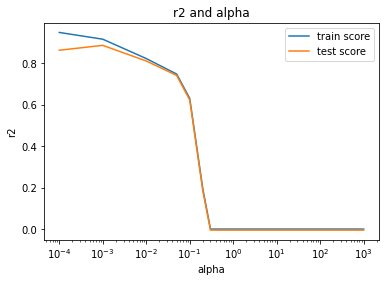

In [108]:
# plotting mean test and train scoes with alpha 
cv_results_lasso['param_alpha'] = cv_results_lasso['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_train_score'])
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.xscale('log')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [109]:
hyper_param['lasso_alpha'] = model_cv_lasso.best_params_['alpha']

In [110]:
alpha = hyper_param['lasso_alpha']

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_lasso, y_train)
lasso.coef_

array([ 2.32727138e-02, -2.49958121e-04, -6.51718024e-02,  5.53146941e-02,
        1.54306612e-02,  0.00000000e+00,  1.23523029e-01,  0.00000000e+00,
        3.76901701e-02,  1.43263814e-02,  6.10687907e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -3.35077759e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.07170369e-02,  0.00000000e+00,
       -7.22679659e-04,  7.16492815e-02,  0.00000000e+00,  4.31020276e-02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  7.92732614e-02, -4.58680430e-02,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.18255484e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  1.07549675e-02, -3.84501472e-02, -0.00000000e+00,
        0.00000000e+00,  

In [111]:
# predict
y_train_lasso_pred = lasso.predict(X_train_lasso)
y_test_lasso_pred = lasso.predict(X_test_lasso)

#Calculate R2
r_square_score_train=round(r2_score(y_train, y_train_lasso_pred), 2)
print("R Square score on train:{}".format(r_square_score_train))
r_square_score=round(r2_score(y_test, y_test_lasso_pred), 2)
print("R Square score on test:{}".format(r_square_score))

R Square score on train:0.91
R Square score on test:0.89


In [112]:
adj_r2 = 1 - (1-r_square_score_train)*(X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-1-X_train_lasso.shape[1])
print("Adjusted R-Squared for Lasso regression is :", adj_r2)

Adjusted R-Squared for Lasso regression is : 0.8715467075038286


We considered all the features while computing adjusted R squared therefore the value is less. Lets recalculate with the number of significant features in Lasso model.

In [113]:
adj_r2 = 1 - (1-r_square_score_train)*(X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-1-71)
print("Adjusted R-Squared for Lasso regression is :", adj_r2)

Adjusted R-Squared for Lasso regression is : 0.9025783972125436


This is close to R squared on training data.

In [114]:
# Lasso model parameters generation
model_parameters = list(lasso.coef_)
model_parameters.insert(0,lasso.intercept_)
model_parameters=[round(x,2) for x in model_parameters]
cols=X_train_lasso.columns
cols=cols.insert(0,"constant")
model_params_lasso = pd.DataFrame({'Feature' : cols, 'Coefficients' : model_parameters, 
                            'Abs_coeff':np.abs(model_parameters)})
model_params_lasso[model_params_lasso['Abs_coeff'] != 0].sort_values(by='Abs_coeff', ascending=False)

,Feature,Coefficients,Abs_coeff
0,constant,11.77,11.77
213,OverallCond_3,-0.19,0.19
7,GrLivArea,0.12,0.12
179,OverallQual_9,0.10,0.10
241,Neighborhood_Crawfor,0.10,0.10
39,Functional_Typ,0.08,0.08
70,SaleType_New,0.08,0.08
89,SaleCondition_Normal,0.07,0.07
214,OverallCond_4,-0.07,0.07
30,MSZoning_FV,0.07,0.07


In [115]:
print("Number of non-zero coefficients", len(model_params_lasso[model_params_lasso['Abs_coeff'] != 0]))

Number of non-zero coefficients 72


## Ridge Regression

We will take all those features from Lasso with non-zero coefficient.

In [116]:
col = model_params_lasso[model_params_lasso['Abs_coeff'] != 0].Feature
col.pop(0)

'constant'

In [117]:
X_train_ridge = X_train[col]
X_test_ridge = X_test[col]
print(X_train_ridge.shape)
print(X_test_ridge.shape)

(933, 71)
(401, 71)


In [118]:
ridge = Ridge()

model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)
model_cv.fit(X_train_ridge, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [119]:
cv_results=pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012881,0.004892,0.006795,0.002160,0.0001,{'alpha': 0.0001},0.932410,0.901395,0.881851,0.913823,0.881496,0.902195,0.019448,20,0.917668,0.923349,0.927854,0.921912,0.929165,0.923990,0.004157
1,0.011545,0.003721,0.005177,0.001424,0.001,{'alpha': 0.001},0.932411,0.901400,0.881859,0.913824,0.881499,0.902199,0.019446,19,0.917668,0.923349,0.927854,0.921912,0.929165,0.923990,0.004157
2,0.011778,0.004039,0.004639,0.000436,0.01,{'alpha': 0.01},0.932422,0.901458,0.881933,0.913829,0.881522,0.902233,0.019429,18,0.917668,0.923349,0.927854,0.921912,0.929165,0.923989,0.004157
3,0.008218,0.001751,0.003507,0.000905,0.05,{'alpha': 0.05},0.932470,0.901683,0.882227,0.913849,0.881624,0.902371,0.019362,17,0.917667,0.923346,0.927852,0.921911,0.929164,0.923988,0.004157
4,0.007057,0.001644,0.005346,0.003624,0.1,{'alpha': 0.1},0.932529,0.901907,0.882532,0.913873,0.881748,0.902518,0.019292,15,0.917666,0.923341,0.927847,0.921910,0.929162,0.923985,0.004156
5,0.005620,0.001874,0.003040,0.000603,0.2,{'alpha': 0.2},0.932643,0.902231,0.883001,0.913916,0.881980,0.902754,0.019183,14,0.917659,0.923324,0.927830,0.921903,0.929155,0.923974,0.004154
6,0.010394,0.003102,0.004252,0.000139,0.3,{'alpha': 0.3},0.932752,0.902452,0.883351,0.913953,0.882196,0.902941,0.019102,13,0.917649,0.923303,0.927809,0.921891,0.929143,0.923959,0.004152
7,0.008932,0.000517,0.003729,0.001010,0.4,{'alpha': 0.4},0.932856,0.902611,0.883624,0.913985,0.882397,0.903094,0.019037,11,0.917635,0.923279,0.927784,0.921877,0.929126,0.923940,0.004150
8,0.002925,0.000301,0.001606,0.000199,0.5,{'alpha': 0.5},0.932955,0.902727,0.883845,0.914012,0.882585,0.903225,0.018985,10,0.917618,0.923252,0.927757,0.921858,0.929107,0.923918,0.004148
9,0.002737,0.000157,0.001630,0.000223,0.6,{'alpha': 0.6},0.933050,0.902814,0.884029,0.914034,0.882761,0.903338,0.018941,9,0.917597,0.923224,0.927727,0.921836,0.929083,0.923894,0.004146


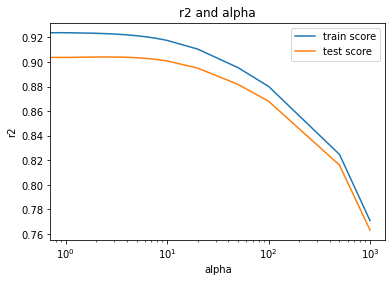

In [120]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.xscale('log')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [121]:
hyper_param['ridge_alpha'] = model_cv.best_params_['alpha']

In [122]:
alpha = hyper_param['ridge_alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_ridge, y_train)
#Predictor Variables from the Model built using Ridge Regression:
ridge.coef_

array([ 0.02383306, -0.05980091,  0.05520868,  0.00876919,  0.11158906,
        0.03186479,  0.0145776 ,  0.00466205, -0.036834  ,  0.09186375,
        0.04320413,  0.08116244, -0.05913123,  0.04791399,  0.03577318,
       -0.05391385, -0.01541253,  0.02362483,  0.09856506,  0.03828352,
        0.01110599,  0.02969378,  0.08400168,  0.03683844, -0.0114541 ,
        0.04412558, -0.03207209, -0.02110029, -0.03581099, -0.04593686,
        0.07013029, -0.01846538, -0.04776819, -0.01706428, -0.00244033,
        0.02366843, -0.03920694, -0.08768307, -0.04452273, -0.02433406,
        0.03649413,  0.08087372,  0.11678109,  0.03360695, -0.01941214,
        0.08062047,  0.06588851, -0.00429907,  0.02296595, -0.12682294,
       -0.08086221, -0.09411135, -0.20006657, -0.07582576, -0.03788532,
        0.05429384,  0.06338077,  0.09996442, -0.08491638,  0.00828158,
        0.04136379,  0.05688935,  0.11276936, -0.05925615, -0.09958395,
        0.03276767,  0.03442244,  0.02909797, -0.0183323 ,  0.01

In [123]:
# predict
y_train_ridge_pred = ridge.predict(X_train_ridge)
y_test_ridge_pred = ridge.predict(X_test_ridge)

#Calculate R2
r_square_score_train=round(r2_score(y_train, y_train_ridge_pred), 2)
print("R Square score on train:{}".format(r_square_score_train))
r_square_score=round(r2_score(y_test, y_test_ridge_pred), 2)
print("R Square score on test:{}".format(r_square_score))

R Square score on train:0.92
R Square score on test:0.9


In [124]:
adj_r2 = 1 - (1-r_square_score_train)*(X_train_ridge.shape[0]-1)/(X_train_ridge.shape[0]-1-X_train_ridge.shape[1])
print("Adjusted R-Squared for Ridge regression is :", adj_r2)

Adjusted R-Squared for Ridge regression is : 0.9134030197444832


In [125]:
# Ridge model parameters generation
model_parameters = list(ridge.coef_)
model_parameters.insert(0,ridge.intercept_)
model_parameters=[round(x,2) for x in model_parameters]
cols=X_train_ridge.columns
cols=cols.insert(0,"constant")
model_params_ridge = pd.DataFrame({'Feature' : cols, 'Coefficients' : model_parameters, 
                            'Abs_coeff':np.abs(model_parameters)})
model_params_ridge.sort_values(by='Abs_coeff', ascending=False)

,Feature,Coefficients,Abs_coeff
0,constant,11.75,11.75
53,OverallCond_3,-0.20,0.20
50,KitchenQual_Fa,-0.13,0.13
43,OverallQual_9,0.12,0.12
5,GrLivArea,0.11,0.11
63,Neighborhood_Crawfor,0.11,0.11
19,SaleType_New,0.10,0.10
58,OverallCond_9,0.10,0.10
65,Neighborhood_MeadowV,-0.10,0.10
38,OverallQual_3,-0.09,0.09


In [126]:
print("Number of non-zero coefficients", len(model_params_ridge[model_params_ridge['Abs_coeff'] != 0]))

Number of non-zero coefficients 69


In [127]:
# hyper parameters for Ridge and Lasso regressions
hyper_param

{'lasso_alpha': 0.001, 'ridge_alpha': 2.0}

# Conclusions

### Lasso Regression
- Optimal Alpha value is **0.001**
- Lasso did feature selection as well
- After building Lasso regression model we have **71 significant features** out of 278. For rest Lasso pushed value of coefficients close to Zero.
- R Square score on train is **0.91**
- R Square score on test is **0.89**
- With Lasso regression the model is able to explain 91% and 89% variance in data on train and test data sets.
- The difference between train and test R Squared is within 5%, so we can say that the model has fit well.
- Top 5 (excluding constant) features for Lasso are:
  1. **constant : 11.77**
  2. **OverallCond_Fair : -0.19**
  3. **GrLivArea : 0.12**
  4. **Neighborhood_Crawfor : 0.10**
  5. **OverallQual_Excellent : 0.09**
  6. **Functional_Typical_Functionality : 0.08**
  7. **SaleType_New : 0.08**
- OverallCond_Fair has negative impact on SalePrice while all other top features positively impact the SalePrice.

### Ridge Regression summary
- We used features selected via Lasso, 71 in total.
- Optimal Alpha value is **2.0**
- After building Ridge regression model we have **68 significant features** out of 71. Ridge regression pushed value of three more coefficients close to Zero.
- R Square score on train is **0.92**
- R Square score on test **0.9**
- With Ridge regression the model is able to explain 92% and 9% variance in data on train and test data sets.
- The difference between train and test R Squared is within 5%, so we can say that the model has fit well.
- The R Squared for Ridge is slightly better than Lasso, however we used Lasso to select features. If we had used RFE for feature selection, we could have good different R Squared.
- Top 5 (excluding constant) features affecting SalePrice for Ridge regression are:
  1. **Constant : 11.75**
  2. **OverallCond_Fair : -0.20**
  3. **KitchenQual_Fair : -0.13**
  4. **OverallQual_Excellent : 0.12**
  5. **GrLivArea : 0.11**
  6. **Neighborhood_Crawfor : 0.11**
- OverallCond_Fair, KitchenQual_Fair negatively impact the SalePrice. All other top features have positive impact on the SalePrice.

### Takeaways for Surprise Housing
- The company should avoid properties with Fair condition of house and kitchen and instead look for properties with Good to Excellent condition.
- The company should focus on properties in Crawfor, NridgHt, Somerst and BrkSide neighborhood with Crawfor being priority. 
- While the company should avoid properties in MeadowV and IDOTRR neighborhood.
- The company should focus on properties with greater Ground floor area.

# End of assignment

### Subjective Question 1

In [128]:
alpha = 0.002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_lasso, y_train)
# Lasso model parameters generation
model_parameters = list(lasso.coef_)
model_parameters.insert(0,lasso.intercept_)
model_parameters=[round(x,2) for x in model_parameters]
cols=X_train_lasso.columns
cols=cols.insert(0,"constant")
model_params_lasso = pd.DataFrame({'Feature' : cols, 'Coefficients' : model_parameters, 
                            'Abs_coeff':np.abs(model_parameters)})
model_params_lasso[model_params_lasso['Abs_coeff'] != 0].sort_values(by='Abs_coeff', ascending=False)

,Feature,Coefficients,Abs_coeff
0,constant,11.82,11.82
213,OverallCond_3,-0.15,0.15
7,GrLivArea,0.13,0.13
241,Neighborhood_Crawfor,0.08,0.08
39,Functional_Typ,0.08,0.08
3,YearBuilt,-0.07,0.07
70,SaleType_New,0.06,0.06
89,SaleCondition_Normal,0.05,0.05
9,GarageArea,0.05,0.05
4,TotalBsmtSF,0.05,0.05


In [129]:
len(model_params_lasso[model_params_lasso['Abs_coeff'] != 0].sort_values(by='Abs_coeff', ascending=False))

51

In [130]:
alpha = 4

ridge = Ridge(alpha=alpha)

ridge.fit(X_train_ridge, y_train)

# Ridge model parameters generation
model_parameters = list(ridge.coef_)
model_parameters.insert(0,ridge.intercept_)
model_parameters=[round(x,2) for x in model_parameters]
cols=X_train_ridge.columns
cols=cols.insert(0,"constant")
model_params_ridge = pd.DataFrame({'Feature' : cols, 'Coefficients' : model_parameters, 
                            'Abs_coeff':np.abs(model_parameters)})
model_params_ridge.sort_values(by='Abs_coeff', ascending=False)

,Feature,Coefficients,Abs_coeff
0,constant,11.76,11.76
53,OverallCond_3,-0.18,0.18
50,KitchenQual_Fa,-0.11,0.11
5,GrLivArea,0.11,0.11
63,Neighborhood_Crawfor,0.11,0.11
43,OverallQual_9,0.10,0.10
19,SaleType_New,0.09,0.09
58,OverallCond_9,0.09,0.09
65,Neighborhood_MeadowV,-0.09,0.09
42,OverallQual_8,0.08,0.08


In [131]:
print("Number of non-zero coefficients", len(model_params_ridge[model_params_ridge['Abs_coeff'] != 0]))

Number of non-zero coefficients 71


---------------------------------------------------------------------------------

### Subjective Question 3

In [132]:
alpha = 0.001

lasso = Lasso(alpha=alpha)
# Top 5 features are not available in incoming data. 
X_train_lasso.pop('OverallCond_3')
X_train_lasso.pop('GrLivArea')
X_train_lasso.pop('Neighborhood_Crawfor')
X_train_lasso.pop('OverallQual_9')
X_train_lasso.pop('Functional_Typ')

lasso.fit(X_train_lasso, y_train)
# Lasso model parameters generation
model_parameters = list(lasso.coef_)
model_parameters.insert(0,lasso.intercept_)
model_parameters=[round(x,2) for x in model_parameters]
cols=X_train_lasso.columns
cols=cols.insert(0,"constant")
model_params_lasso = pd.DataFrame({'Feature' : cols, 'Coefficients' : model_parameters, 
                            'Abs_coeff':np.abs(model_parameters)})
model_params_lasso[model_params_lasso['Abs_coeff'] != 0].sort_values(by='Abs_coeff', ascending=False)

,Feature,Coefficients,Abs_coeff
0,constant,11.85,11.85
213,OverallCond_7,0.11,0.11
182,FullBath_3,0.10,0.10
53,HouseStyle_1Story,-0.09,0.09
56,HouseStyle_2Story,0.09,0.09
216,BedroomAbvGr_1,-0.09,0.09
214,OverallCond_8,0.09,0.09
49,MSSubClass_160,-0.09,0.09
29,MSZoning_FV,0.09,0.09
206,KitchenQual_Fa,-0.08,0.08


In [133]:
alpha = 2

ridge = Ridge(alpha=alpha)
# Top 5 features are not available in incoming data. 
X_train_ridge.pop('OverallCond_3')
X_train_ridge.pop('KitchenQual_Fa')
X_train_ridge.pop('OverallQual_9')
X_train_ridge.pop('GrLivArea')
X_train_ridge.pop('Neighborhood_Crawfor')

ridge.fit(X_train_ridge, y_train)

# Ridge model parameters generation
model_parameters = list(ridge.coef_)
model_parameters.insert(0,ridge.intercept_)
model_parameters=[round(x,2) for x in model_parameters]
cols=X_train_ridge.columns
cols=cols.insert(0,"constant")
model_params_ridge = pd.DataFrame({'Feature' : cols, 'Coefficients' : model_parameters, 
                            'Abs_coeff':np.abs(model_parameters)})
model_params_ridge.sort_values(by='Abs_coeff', ascending=False)

,Feature,Coefficients,Abs_coeff
0,constant,11.84,11.84
44,FullBath_3,0.17,0.17
55,BedroomAbvGr_1,-0.14,0.14
13,MSSubClass_70,0.11,0.11
41,OverallQual_8,0.10,0.10
60,Neighborhood_MeadowV,-0.10,0.10
37,OverallQual_3,-0.09,0.09
21,HalfBath_1,0.09,0.09
18,SaleType_New,0.09,0.09
16,HouseStyle_1Story,-0.09,0.09
